In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import PIL

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Section 1

## Project  (Dynamic Systems Modeling): A case study on differential drive mobile robot in position, velocity and heading. 

### Date: Oct 2023

### Leo Doak, Audrey Warrene 

### Abstract: In this project, we aim to model the kinematic model of a differential drive mobile robot. In this model the the accelerations of the left and right wheel are the system inputs. We model the velocity,angular velocity, position and the heading. We test the system via standard inputs through implenting the discrete time function of the model. We analyze the scenarios that included different intital conditions and a scenario where an input is changed during the simulation. For each test, a plot and a description of the behavior is provided. We also modeled the behavior of the model through the use of PIDs and MPCs in order to reach a desired linear velocity, a desired angular velocity, and a desired angular and desired linear velocity. The aim of the PID and MPC is to alter the left and right wheel accelerations in order to reach a target velocity, target angular velocity, or a target angular and target velocity. 

# Section 2

## Dynamics model of the system

Formulas Given:

$\dot{\mathbf{x}} = \cos(\theta)v\\
\dot{\mathbf{y}} = \sin(\theta)v\\
\dot{\mathbf{\theta}} = w\\
\dot{\mathbf{v}} = \frac{r}{2}(\ddot{\varnothing}_{R} + \ddot{\varnothing}_{L})\\
\dot{\mathbf{w}} = \frac{r}{2b}(\ddot{\varnothing}_{R} - \ddot{\varnothing}_{L})$

$x,y$:  the horizontal and vertical postions of the center of the robot <br>
$\theta$: is the angular position(heading) of the robot <br>
$v$: the forward velocity <br>
$w$: is the angular velocity <br>
$r$: radius of the wheel <br>
$b$: distace of each wheel to the center of the robot <br>
$\ddot{\varnothing}_{L},\ddot{\varnothing}_{R}$ :Angular accelerations of left and right wheel, also the system inputs <br>
$r = 0.02\text{ m}$ and $b = 0.05 \text{ m} $ 


# Section 3

## Examples of applications in the real world

 

The benefits of using these systems in the real-world include the simplicity of the design itself, making the system itself much easier to operate/create. They also are more energy efficent, considering less mechanics go into operating the system, and only two motors are required for the wheels. Lastly, another advantage include their scalability: anywhere from small toys to larger exploration vehicles.

Some examples of real-life use include the rover, electronic wheelchairs, warehouse robots (such as Kiva systems), etc.

A real life example of DDR can be seen in this link, https://42bots.com/tutorials/differential-steering-with-continuous-rotation-servos-and-arduino/. 

Inputs in our use-case include: Speed, which helps with the control of the robot's movement, with a direct focus on speed regulation for each wheel's individual motor. By managing this input, we can alter the robot's overall velocity, trajectory, and turning radius.


Outputs can be measured using many sensors, such as proximity (infared) sensors, accelerometers/gyrometers, and encoders (specifically rotary encoders). The units used will typically be in meters per second (m/s), or rotations per minute (rpm).

# Section 4
## Implementation of the dynamic model (the function/solver used for implementing the equations)



The discrete-time format is:

${x}_{k+1} = \Delta t (cos(\theta_{k})v_{k}) + x_{k}\\
{y}_{k+1} = \Delta t (sin(\theta_{k})v_{k})+ y_{k}\\
{\theta}_{k+1} = \Delta t(w_{k}) + {\theta_{k}}\\
v_{k+1} = \Delta t (\frac{r}{2}(\ddot{\varnothing}_{R} + \ddot{\varnothing}_{L}))+v_{k} \\
w_{k+1} = \Delta t(\frac{r}{2b}(\ddot{\varnothing}_{R} - \ddot{\varnothing}_{L}))+w_{k}$

 

In [ ]:
#Test function using while loop, to show when left wheel acceleration is 5 and right wheel acceleration is 8
import math
import numpy as np
import matplotlib.pyplot as plt

r = 0.02  #radius of the wheel in meters
b = 0.05  #length of half of axle, in meters
t_0 = 0  #starting time 
t_f = 5  #ending time 
dt = 0.1 #time increment 
x_k =0   #original x value, 0 
y_k =0  #original y value, 0 
w_k = 0  #angular velocity
v_k = 0  #velocity
acc_l = 5  #acceleration of the left wheel 
acc_r = 8  #acceleration of the right wheel
theta_k = math.pi/4  #heading of the robot, set to pi/4 becuase of diagram wanted it to be easy to visualize 
y_list = []  #initializing y list
x_list = []  #initializing x list
time_list = []  #initializing time list
v_list=[]  #intializing velocity list 
heading = []  #intialiing heading 
ang_vel_list = []  #intializing angular velocity list
t = t_0 #setting t to the start poistion

while t < t_f:  #the discrete time format in code 
    v_list.append(v_k)
    x_list.append(x_k)
    y_list.append(y_k)
    time_list.append(t)
    heading.append(theta_k)
    ang_vel_list.append(w_k)
    v_k1 = dt*((r/2)*(acc_r + acc_l)) + v_k
    v_k = v_k1
    w_k1 = dt*((r/(2*b)) * (acc_r - acc_l))+ w_k
    w_k = w_k1
    theta_k1 = dt*(w_k) + theta_k
    theta_k = theta_k1
    x_k1 = dt*(math.cos(theta_k)*v_k)+x_k
    x_k = x_k1
    y_k1 = dt*(math.sin(theta_k)*v_k)+y_k
    y_k = y_k1
    t += dt

In [31]:
#Programs Used to implement the the discreet time continous model 
#NEED TO RUN THIS FIRST OR ELSE THE OTHER CODES BELOW WON'T FUNCTION CORRECTLY 

import math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation 
#!pip install do-mpc[full]
# Import do_mpc package:
import do_mpc
from casadi import *
from casadi.tools import *

def set_variables_back():  #sets all the variables back to their original position
    r = 0.02
    b = 0.05
    t_0 = 0
    x_k =0
    y_k =0
    w_k = 0
    v_k = 0
    y_list = []
    x_list = []
    time_list = []
    v_list=[]
    heading = []
    ang_vel_list = []
    t = t_0
    t_f = 5
    dt = 0.1
    theta_k = math.pi/4 
    return r,b,t_0, x_k, y_k,w_k, v_k,y_list, x_list,time_list,v_list, heading, ang_vel_list, t, t_f, dt, theta_k


def discrete_equation(r,b,t,t_0, t_f, dt,x_k, y_k, w_k, v_k,theta_k,acc_l, acc_r):  #the discrete time format in the function, recursively goes through by incrementing the time by the time increment 
    if t < t_f:
        time_list.append(t)
        v_list.append(v_k)
        heading.append(theta_k)
        x_list.append(x_k)
        y_list.append(y_k)
        ang_vel_list.append(w_k)
        v_k1 = dt * ((r / 2) * (acc_r + acc_l)) + v_k
        v_k = v_k1
        w_k1 = dt * ((r / (2 * b)) * (acc_r - acc_l)) + w_k
        w_k = w_k1
        theta_k1 = dt * (w_k) + theta_k
        theta_k = theta_k1
        x_k1 = dt * (math.cos(theta_k) * v_k) + x_k
        x_k = x_k1
        y_k1 = dt * (math.sin(theta_k) * v_k) + y_k
        y_k = y_k1
        return discrete_equation(r,b,t+dt,t_0,t_f, dt,x_k, y_k, w_k, v_k, theta_k, acc_l, acc_r)
    createplots(x_list, y_list, time_list, v_list, heading, ang_vel_list)
    

def createplots(x_list, y_list, time_list, v_list, heading, ang_vel_list): 
    fig, axs = plt.subplots(4, 1, figsize=(15, 15))
    fig.tight_layout(pad=5.0)

    axs[0].plot(x_list,y_list)
    axs[0].set_xlabel('x')
    axs[0].set_ylabel('y')
    axs[0].grid()

    axs[1].plot(time_list, v_list)
    axs[1].set_xlabel('time (seconds)')
    axs[1].set_ylabel('velocity')
    axs[1].grid()

    axs[2].plot(time_list, heading)
    axs[2].set_xlabel('time (seconds)')
    axs[2].set_ylabel('theta (heading)')
    axs[2].grid()

    axs[3].plot(time_list, ang_vel_list)
    axs[3].set_xlabel('time (seconds)')
    axs[3].set_ylabel('theta (angular velocity)')
    axs[3].grid()
    
    plt.show()
    
                  
#Program: animateplots
#Description: Takes in a two lists and uses one for the independent variable and the other for the dependent variable, creates an animated plot using these lists
#Source: Used https://matplotlib.org/stable/api/animation_api.html for the general structure of the function, used https://towardsdatascience.com/animate-data-using-python-dd558e9103d
#to then see that I could use a list as an input so instead of making the animation frame by frame while the data is being collected it makes it from prexisting lists. 

def animateplots(ind,dep,name):
    fig, ax = plt.subplots()
    xdata, ydata = [], []
    ln, = plt.plot([], [], 'ro')


    def init():
        ax.set_xlim(min(ind),max(ind))
        ax.set_ylim(min(dep),max(dep))
        return ln,


    def update(i):
        x = ind[0:i]
        y = dep[0:i]
        ln.set_data(x,y)
        return ln,


    ani = FuncAnimation(fig, func = update,frames = 100 ,interval = 50,init_func=init)
    
    %time ani.save(name, writer='imagemagick', fps=30)
    
#Program: gifname
#Description: Takes in the string, i.e x_list,y_list..., and the acceleration of the wheels to create the different gifnames. 
#So didn't have to keep on renaming then 
#Retuns: A gifname that can be copied into a markdown tab and then the gif will play,
#Source: used the code from this to get the format for the markdown call to get the gif, https://www.kaggle.com/code/subinium/how-to-use-matplotlib-animations-in-kaggle.

def gifname(string1, string2, acc_l, acc_r):
    name = 'ani'+string1[0]+string2[0]+str(acc_l)+'&'+str(acc_r)+'.gif'
    gifcall = '![](./' + name+ ')'
    print("GIFname for markdown, plots",string1,'againest',string2,":",gifcall)
    return name 
    
def createanimatedplots(x_list, y_list, time_list, v_list, heading, ang_vel_list, acc_l, acc_r): 
    animateplots(ind=x_list, dep=y_list, name =  gifname('x_list', 'y_list', acc_l, acc_r) )
    animateplots(ind=time_list, dep=v_list, name = gifname('time_list', 'v_list', acc_l, acc_r) )
    animateplots(ind=time_list, dep=heading, name = gifname('time_list','heading', acc_l, acc_r) )
    animateplots(ind=time_list, dep=ang_vel_list, name = gifname('time_list', 'ang_vel_list', acc_l, acc_r))
    
    
def saturate(signal, saturation_level):
    # apply the upper-bound for saturation
    if signal > saturation_level:
        output = saturation_level
    # apply the lower-bound for saturation
    elif signal < -saturation_level:
        output = -saturation_level
    # do not change the signal in other cases
    else:
        output = signal
    return output    
    

# Section 5
## Tests for different inputs & initial conditions

In [ ]:
import math
import numpy as np
import matplotlib.pyplot as plt

#where the acceleration of the left side is larger than the acceleration of the right side

r,b,t_0, x_k, y_k,w_k, v_k, y_list, x_list,time_list,v_list, heading, ang_vel_list ,t, t_f, dt, theta_k =set_variables_back()

#left more than right 
discrete_equation(r,b,t,t_0, t_f, dt,x_k, y_k, w_k, v_k,theta_k ,acc_l=8, acc_r=5)

fig, axs = plt.subplots(4, 1, figsize=(15, 15))
fig.tight_layout(pad=5.0)

axs[0].plot(x_list,y_list)
axs[0].set_xlabel('x')
axs[0].set_ylabel('y')
axs[0].grid()


axs[1].plot(time_list, v_list)
axs[1].set_xlabel('time (seconds)')
axs[1].set_ylabel('velocity')
axs[1].grid()



axs[2].plot(time_list, heading)
axs[2].set_xlabel('time (seconds)')
axs[2].set_ylabel('theta (heading)')
axs[2].grid()

axs[3].plot(time_list, ang_vel_list)
axs[3].set_xlabel('time (seconds)')
axs[3].set_ylabel('theta (angular velocity)')
axs[3].grid()

plt.show()

When the acceleration of the left wheel is 8 and the acceleration of the right wheel is 5. When the acceleration of the left wheel is greater than the acceleration of the right wheel, we would expect the the robot to move to the right. This is proven by the x and y plot which shows the eclpise shape and ends off track of the eclipse because of the continously increasing velocity. The velocity increase as becuase the robot is moving in a positive direction. The heading decreases becuase the robot is turning to the right and the angular velocity decreases along with that right turn. 

In [ ]:

#when the acceleration of the right wheel is larger than the acceleration of the left wheel 

r,b,t_0, x_k, y_k,w_k, v_k,y_list, x_list,time_list,v_list, heading, ang_vel_list ,t, t_f, dt, theta_k =set_variables_back()
discrete_equation(r,b,t,t_0, t_f, dt,x_k, y_k, w_k, v_k,theta_k ,acc_l=5, acc_r=8)

fig, axs = plt.subplots(4, 1, figsize=(15, 15))
fig.tight_layout(pad=5.0)

print("When left is lower than right")
axs[0].plot(x_list,y_list)
axs[0].set_xlabel('x')
axs[0].set_ylabel('y')
axs[0].grid()


axs[1].plot(time_list, v_list)
axs[1].set_xlabel('time (seconds)')
axs[1].set_ylabel('velocity')
axs[1].grid()



axs[2].plot(time_list, heading)
axs[2].set_xlabel('time (seconds)')
axs[2].set_ylabel('theta (heading)')
axs[2].grid()

axs[3].plot(time_list, ang_vel_list)
axs[3].set_xlabel('time (seconds)')
axs[3].set_ylabel('theta (angular velocity)')
axs[3].grid()

plt.show()

When the acceleration of the left wheel is at 5 and the acceleration of the right wheel is at 8, we would expect the robot to turn to the left. This is proven by the x and y plot where it goes in an eclipse shape but finishes outside the eclipse because the velocity continously increases. The heading increases which makes sense since robot is moving to the left. The the angular velocity also increases because the robot is turning.

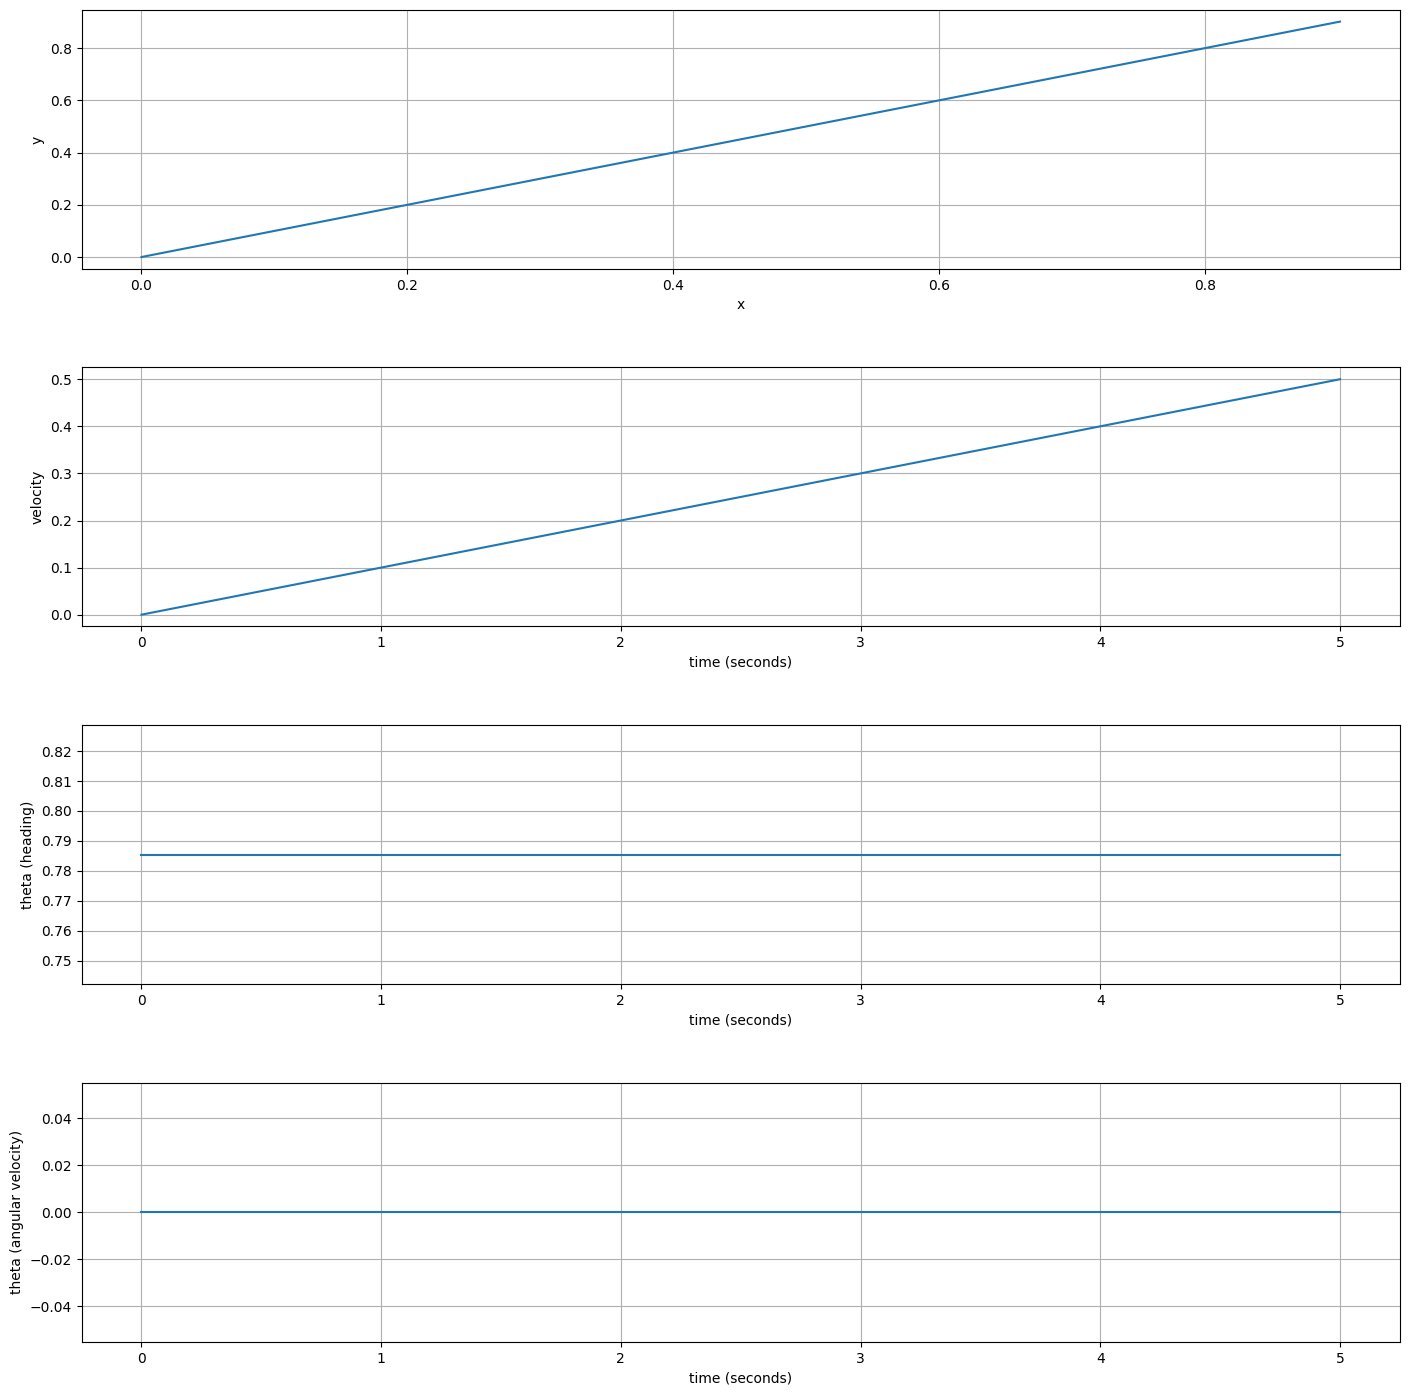

When left equals right


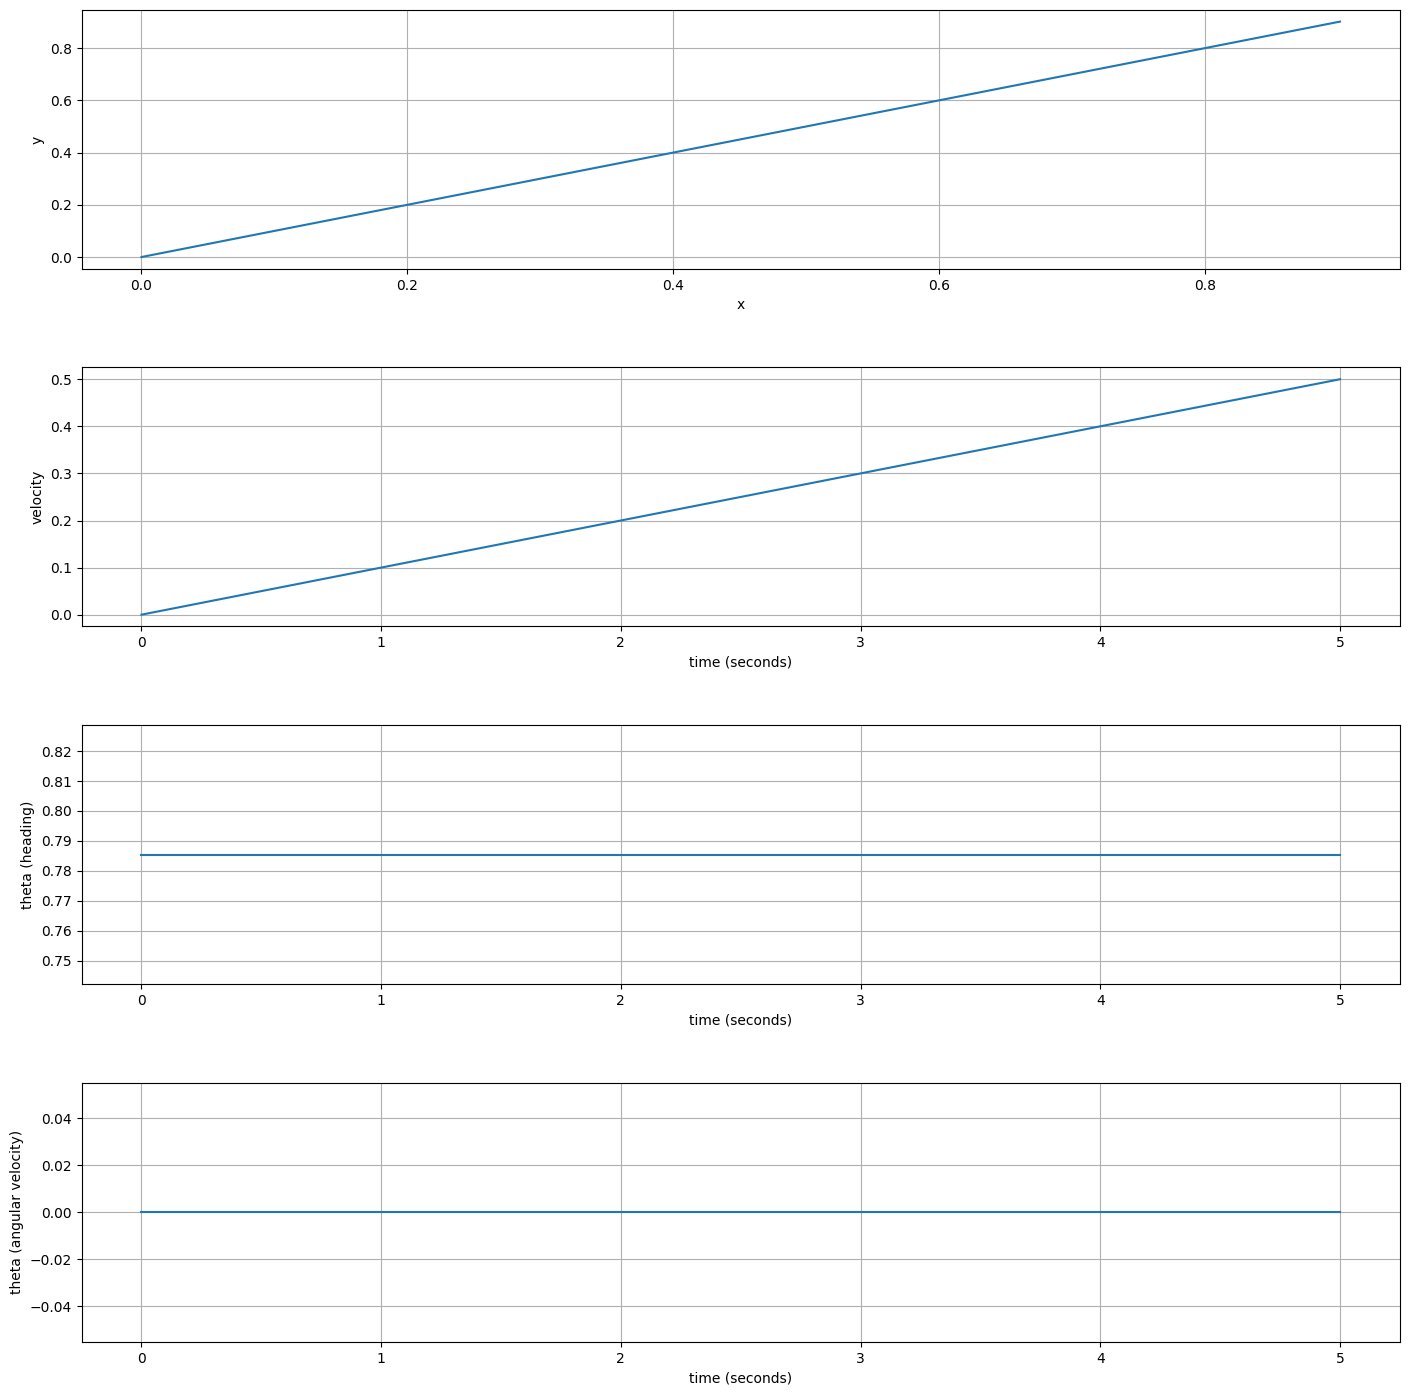

In [32]:
#when the acceleration of the left and right wheels are the same 

r,b,t_0, x_k, y_k,w_k, v_k,y_list, x_list,time_list,v_list, heading, ang_vel_list ,t, t_f, dt, theta_k =set_variables_back()

#left more than right 
discrete_equation(r,b,t,t_0, t_f, dt,x_k, y_k, w_k, v_k,theta_k ,acc_l=5, acc_r=5)

fig, axs = plt.subplots(4, 1, figsize=(15, 15))
fig.tight_layout(pad=5.0)

print("When left equals right")
axs[0].plot(x_list,y_list)
axs[0].set_xlabel('x')
axs[0].set_ylabel('y')
axs[0].grid()


axs[1].plot(time_list, v_list)
axs[1].set_xlabel('time (seconds)')
axs[1].set_ylabel('velocity')
axs[1].grid()



axs[2].plot(time_list, heading)
axs[2].set_xlabel('time (seconds)')
axs[2].set_ylabel('theta (heading)')
axs[2].grid()

axs[3].plot(time_list, ang_vel_list)
axs[3].set_xlabel('time (seconds)')
axs[3].set_ylabel('theta (angular velocity)')
axs[3].grid()

plt.show()

When both the left and right acceleration of the wheel are set to 5. We would expect the robot to move in a straight line along the original heading. From our x and y plot, this is evident. The velocity increases because the robot is moving in a positive direction but since there is no turning of the robot the heading and the angular velocity stay constant, the heading stays at the original heading and the angular velocity stays at 0. 

In [ ]:
#when the acceleration of the left wheel is negative and the acceleration of the right wheel is positive, but they have the same absolute value 
r,b,t_0, x_k, y_k,w_k, v_k,y_list, x_list,time_list,v_list, heading, ang_vel_list ,t, t_f, dt, theta_k =set_variables_back()

#left more than right 
discrete_equation(r,b,t,t_0, t_f, dt,x_k, y_k, w_k, v_k,theta_k ,acc_l= -5, acc_r= 5 )

fig, axs = plt.subplots(4, 1, figsize=(15, 15))
fig.tight_layout(pad=5.0)

axs[0].plot(x_list,y_list)
axs[0].set_xlabel('x')
axs[0].set_ylabel('y')
axs[0].grid()

axs[1].plot(time_list, v_list)
axs[1].set_xlabel('time (seconds)')
axs[1].set_ylabel('velocity')
axs[1].grid()

axs[2].plot(time_list, heading)
axs[2].set_xlabel('time (seconds)')
axs[2].set_ylabel('theta (heading)')
axs[2].grid()

axs[3].plot(time_list, ang_vel_list)
axs[3].set_xlabel('time (seconds)')
axs[3].set_ylabel('theta (angular velocity)')
axs[3].grid()

plt.show()

When the left wheel acceleration is -5 and the right wheel acceleration is 5.  We would expect the wheel accelerations to cancel out and cause the robot to spin around 0,0. This can be seen from the x and y plot. Where there are no values because the robot spins. The velocity stays at 0 becuase there is no forward or backward movement in any direction. But the heading and the angular velocity increase as the robot spins. From this we can also see that the robot would spin in a counter-clockwise direction as the heading increases positive way and not a negative way.

In [ ]:
#when the acceleration of the right wheel is negative and the acceleration of the left wheel is positive, both have the same absolute value 

r,b,t_0, x_k, y_k,w_k, v_k,y_list, x_list,time_list,v_list, heading, ang_vel_list ,t, t_f, dt, theta_k =set_variables_back()

#left more than right 
discrete_equation(r,b,t,t_0, t_f, dt,x_k, y_k, w_k, v_k,theta_k ,acc_l= -5, acc_r= -5 )

fig, axs = plt.subplots(4, 1, figsize=(15, 15))
fig.tight_layout(pad=5.0)

axs[0].plot(x_list,y_list)
axs[0].set_xlabel('x')
axs[0].set_ylabel('y')
axs[0].grid()


axs[1].plot(time_list, v_list)
axs[1].set_xlabel('time (seconds)')
axs[1].set_ylabel('velocity')
axs[1].grid()



axs[2].plot(time_list, heading)
axs[2].set_xlabel('time (seconds)')
axs[2].set_ylabel('theta (heading)')
axs[2].grid()

axs[3].plot(time_list, ang_vel_list)
axs[3].set_xlabel('time (seconds)')
axs[3].set_ylabel('theta (angular velocity)')
axs[3].grid()

plt.show()

When both of the acceleration of the left and right wheels are set to -5. We would expect the robot to move in a reverse direction. From out plot this seems to be evident where x and y posistions starts from 0,0 and moves in a negative linear direction. The velocity decreases in negative which makes sense becuase it is heading backwards. The heading stays the same because both wheels have the same acceleration. This is the same for the angular velocity as well as the robot is not turning.

In [ ]:
#when the acceleration of the left wheel is negative and the accelration of the right wheel is positive, acceleration of left wheel has a higher absolute value than the acceleration of the right wheel 
r,b,t_0, x_k, y_k,w_k, v_k,y_list, x_list,time_list,v_list, heading, ang_vel_list ,t, t_f, dt, theta_k =set_variables_back()

#left more than right 
discrete_equation(r,b,t,t_0, t_f, dt,x_k, y_k, w_k, v_k,theta_k ,acc_l= -8, acc_r= 5 )

fig, axs = plt.subplots(4, 1, figsize=(15, 15))
fig.tight_layout(pad=5.0)

axs[0].plot(x_list,y_list)
axs[0].set_xlabel('x')
axs[0].set_ylabel('y')
axs[0].grid()


axs[1].plot(time_list, v_list)
axs[1].set_xlabel('time (seconds)')
axs[1].set_ylabel('velocity')
axs[1].grid()



axs[2].plot(time_list, heading)
axs[2].set_xlabel('time (seconds)')
axs[2].set_ylabel('theta (heading)')
axs[2].grid()

axs[3].plot(time_list, ang_vel_list)
axs[3].set_xlabel('time (seconds)')
axs[3].set_ylabel('theta (angular velocity)')
axs[3].grid()

plt.show()

For this plot the acceleration of the left wheel is set to -8 and the acceleration of the right wheel is set to 5. From our plot we can see that that the velocity would decrease as the left wheel has a greater negative acceleration than the positive acceleration of the right wheel. The right wheel's acceleration is not enough to cancel the left wheel acceleration, therfore the velocity decreases. The heading and the angular velocity both increase,as expected because the the robot does these small spins to its left, which causes the values to increse.

In [ ]:
#when the acceleration of the left wheel is positive and the acceleration of the right wheel is negaive, the absolute value of the acceleration of the left wheel is higher than the absolute value of the acceleration of the right wheel 

r,b,t_0, x_k, y_k,w_k, v_k,y_list, x_list,time_list,v_list, heading, ang_vel_list ,t, t_f, dt, theta_k =set_variables_back()

#left more than right 
discrete_equation(r,b,t,t_0, t_f, dt,x_k, y_k, w_k, v_k,theta_k ,acc_l= 8, acc_r= -5 )

fig, axs = plt.subplots(4, 1, figsize=(15, 15))
fig.tight_layout(pad=5.0)

axs[0].plot(x_list,y_list)
axs[0].set_xlabel('x')
axs[0].set_ylabel('y')
axs[0].grid()


axs[1].plot(time_list, v_list)
axs[1].set_xlabel('time (seconds)')
axs[1].set_ylabel('velocity')
axs[1].grid()



axs[2].plot(time_list, heading)
axs[2].set_xlabel('time (seconds)')
axs[2].set_ylabel('theta (heading)')
axs[2].grid()

axs[3].plot(time_list, ang_vel_list)
axs[3].set_xlabel('time (seconds)')
axs[3].set_ylabel('theta (angular velocity)')
axs[3].grid()

plt.show()

For this scenario the left wheel acceleration is set to 8 and the right acceleration is set to -5. We had assumed that this would mean that the robot would spin around and not cover much distance. From out plot this seems to be evident. From the plot the velocity still continues to increase but at a very slow rate and the angular velocity grows steadily more negative, which is because of the the negative right acceleration and how it would pull the robot in an increased right direction, which would lead to a negative angular velocity.

In [ ]:
#Function using while loop to see how the function would change if the acceleration of the right and left wheel was changed to 0 after 3 seconds, uses the test function

import math
import numpy as np
import matplotlib.pyplot as plt

r = 0.02
b = 0.05
t_0 = 0 
t_f = 5
dt = 0.1
x_k =0
y_k =0
w_k = 0
v_k = 0 
acc_l = 5
acc_r = 8
theta_k = math.pi/4
y_list = []
x_list = []
time_list = []
v_list=[]
heading = []
ang_vel_list = []
t = t_0 

while t < t_f:
    if t > 3: 
        acc_l = 0 
        acc_r = 0
    v_list.append(v_k)
    x_list.append(x_k)
    y_list.append(y_k)
    time_list.append(t)
    heading.append(theta_k)
    ang_vel_list.append(w_k)
    v_k1 = dt*((r/2)*(acc_r + acc_l)) + v_k
    v_k = v_k1
    w_k1 = dt*((r/(2*b)) * (acc_r - acc_l))+ w_k
    w_k = w_k1
    theta_k1 = dt*(w_k) + theta_k
    theta_k = theta_k1
    x_k1 = dt*(math.cos(theta_k)*v_k)+x_k
    x_k = x_k1
    y_k1 = dt*(math.sin(theta_k)*v_k)+y_k
    y_k = y_k1
    t += dt
    #print(x_k, y_k)
    
fig, axs = plt.subplots(4, 1,figsize=(15,15))
# plot the first state vs time
fig.tight_layout(pad=5.0)


axs[0].plot(x_list,y_list)
axs[0].set_xlabel('x')
axs[0].set_ylabel('y')
axs[0].grid()


axs[1].plot(time_list, v_list)
axs[1].set_xlabel('time (seconds)')
axs[1].set_ylabel('velocity')
axs[1].grid()



axs[2].plot(time_list, heading)
axs[2].set_xlabel('time (seconds)')
axs[2].set_ylabel('theta (heading)')
axs[2].grid()

axs[3].plot(time_list, ang_vel_list)
axs[3].set_xlabel('time (seconds)')
axs[3].set_ylabel('theta (angular velocity)')
axs[3].grid()

plt.show()

For this plot the left acceleration is set to 5 and the right acceleration is set to 8. Then after 3 seconds the left and right acceleration of the wheels were set to 0. We had assumed that the velocity would stabilize and stay constant from that point forward. From out plot this seems to happen as the the angular velocity and the velocity both stabilize. The remaining velocity and angular velocity continues to move the heading in the last direction of the heading, which is shown in the plot.

In [ ]:
#Code Purpose: Takes the lists created from the discrete_function and puts them into 
# the createanimatedplots that ouputs the names of the gifs that are saved in the ouput of the 
# the kaggle. In order to show these gifs, they have to be copied into a markdown tab
# this example uses a right acceleration of 2 and a left acceleration of 3. 
#USED FOR THE SLIDES

r,b,t_0, x_k, y_k,w_k, v_k,y_list, x_list,time_list,v_list, heading, ang_vel_list ,t, t_f, dt, theta_k = set_variables_back()
acc_l = 3
acc_r = 2

discrete_equation(r,b,t,t_0, t_f, dt,x_k, y_k, w_k, v_k,theta_k ,acc_l, acc_r)

createanimatedplots(x_list, y_list, time_list, v_list, heading, ang_vel_list, acc_l, acc_r)

# Section 6
## Controllers: Implement at least two different controllers and compare the results.

- Controller 1: PID controllers
- Controller 2: Model Predictive Control (MPC)


## Solving the Matrix :

$
A\ =\ \left[\begin{matrix}\frac{r}{2}&\frac{r}{2}\\\frac{r}{2b}&\frac{-r}{2b}\\\end{matrix}\right]\ \\
B = \left[\begin{matrix}v\\w\\\end{matrix}\right]\\
X = \left[\begin{matrix}\theta_R\\\theta_L\\\end{matrix}\right] \\
\left[\begin{matrix}v\\w\\\end{matrix}\right]\ =\ \left[\begin{matrix}\frac{r}{2}&\frac{r}{2}\\\frac{r}{2b}&\frac{-r}{2b}\\\end{matrix}\right]\ast\left[\begin{matrix}\theta_R\\\theta_L\\\end{matrix}\right]\\
A^{-1}B\ =\ X $

In [ ]:
#Function purpose: To solve the matrix to solve for what acceleration values would equate to a certain angular and linear velocity

import numpy as np
r = 0.02  #radius of wheel 
b = 0.05  #


def solve_matrix(v,w):   
    B=np.array([[v],[w]])

    A = np.array([[r/2, r/2],
                [r/(2*b),-1 * r/(2*b)]])
    A_inv=np.linalg.inv(A)
    X = np.matmul(A_inv, B)
    print(X)
print("Matrix solved where the linear velocity is 1 and the angular velocity is 0, the right and left wheel acceleration is:\n")
solve_matrix(1,0)
print("Matrix solved where the linear velocity is 0 and the angular velocity is 1, the right and left wheel acceleration is:\n")
solve_matrix(0,1)
print("Matrix solved where the linear velocity is 1 and the angular velocity is 1, the right and left wheel acceleration is:\n")
solve_matrix(1,1)

$V=1\ ,\ B=\left[\begin{matrix}1\\0\\\end{matrix}\right],\ X=\left[\begin{matrix}50\\50\\\end{matrix}\right] \\
W=1\ ,\ B=\left[\begin{matrix}0\\1\\\end{matrix}\right],\ X=\left[\begin{matrix}2.5\\-2.5\\\end{matrix}\right]\\ 
W=1,V=1\ ,\ B=\left[\begin{matrix}1\\1\\\end{matrix}\right],\ X=\left[\begin{matrix}52.5\\47.5\\\end{matrix}\right]\\
\left[\begin{matrix}50\\50\\\end{matrix}\right]+\ \left[\begin{matrix}2.5\\-2.5\\\end{matrix}\right]=\left[\begin{matrix}52.5\\47.5\\\end{matrix}\right]\ \text{therefore,}\left[\begin{matrix}1\\0\\\end{matrix}\right]+\ \left[\begin{matrix}0\\1\\\end{matrix}\right]=\ \left[\begin{matrix}1\\1\\\end{matrix}\right]$

Since I know that we need 2 pids, one for each of the wheels to get to a desired velocity or either a desired angular velocity. The error is calculated from the the desired minus the current and since we need it to get the error for both the linear and angular velocity for each wheel. This would mean that we would need 4 PIDS to control the wheel accelerations to get to a desired linear and angular velocity. 

##  PID SECTION EXAMPLES: 
5 Examples: 
(where V is the desired velocity and W  is the desired angular velocity)

 * EX #1: V = 1 
 * EX #2: W = 1 (Using solved matrix values)
 * EX #3: W = 1 (Setting left acceleration to 0)
 * EX #4: W = 1 , V = 1 (#2)
 * EX #5: W = 1 , V = 1 (using #3)

### EX: #1 V = 1

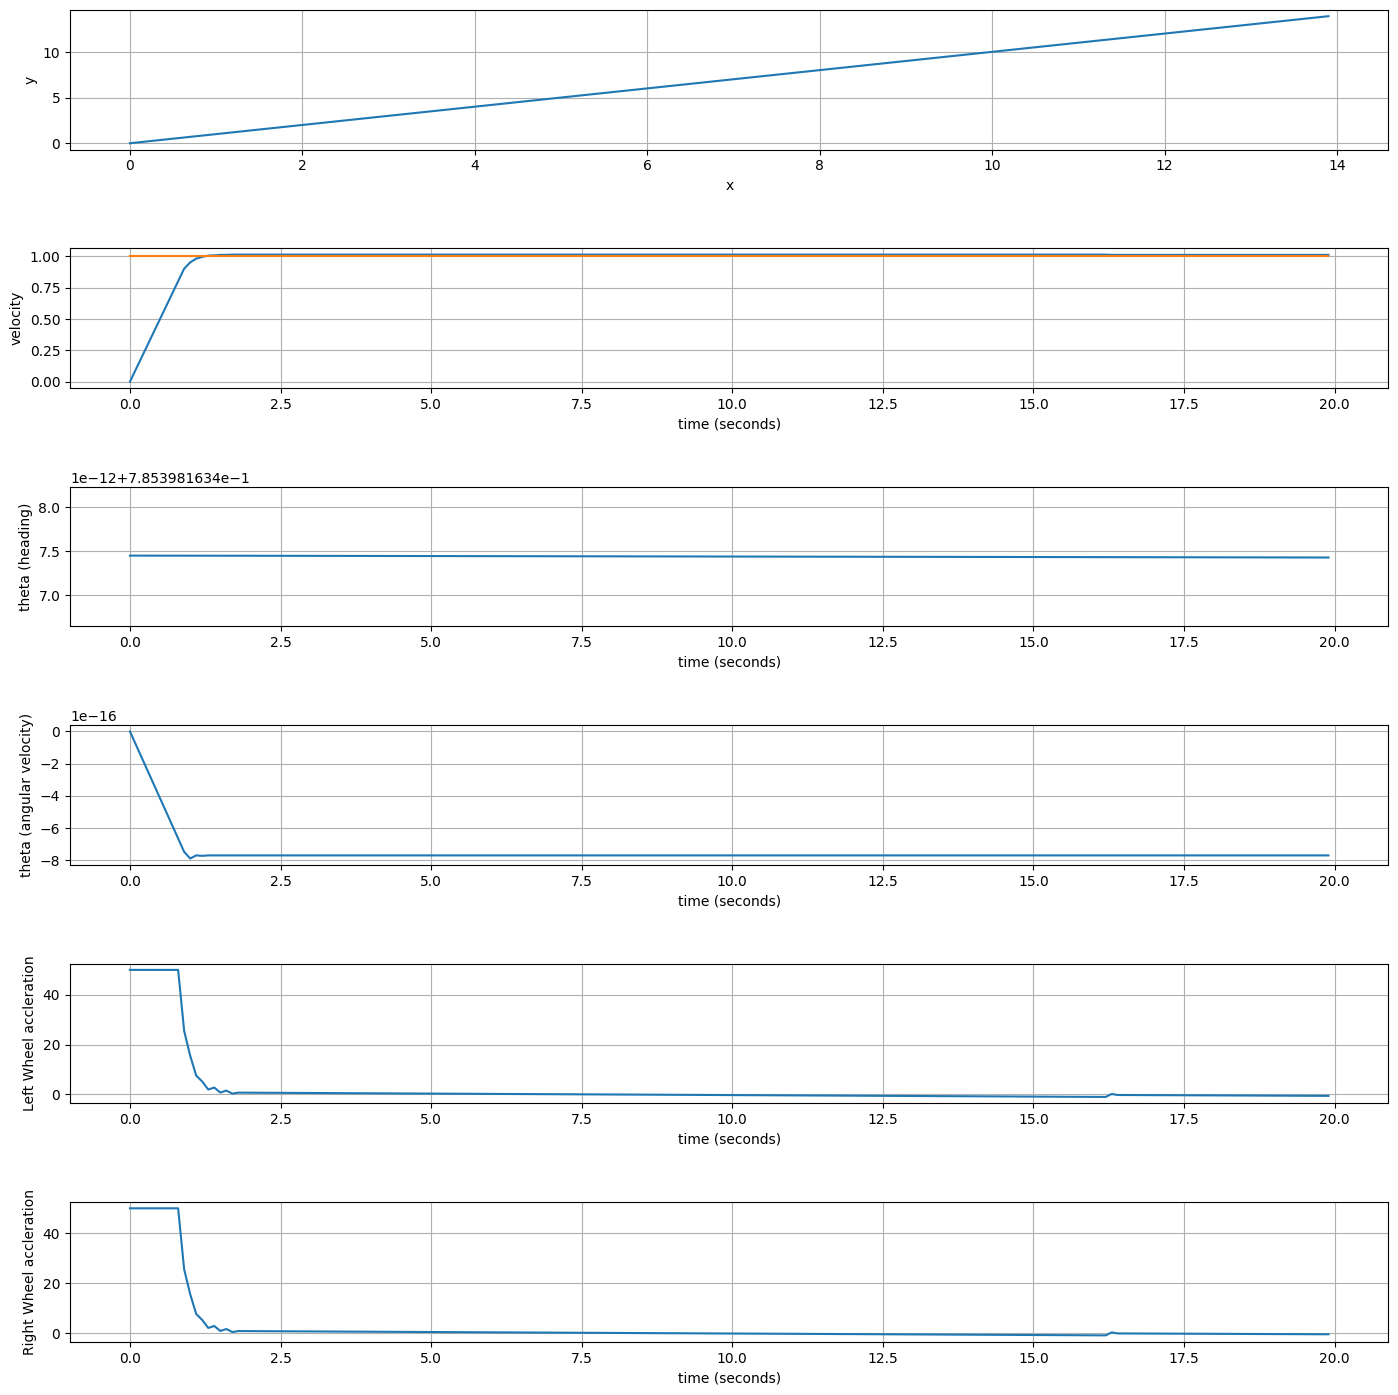

Percentage of overshoot: 1.20%
Ess (m): -0.010000000000000009
Peak time: 1.7000000000000002 seconds


In [33]:
#EX 1 : V=1 
#Code purpose: To change the right and left wheel accelerations accordingly using a PID controller to reach a desired velocity of 1
#Code for the estimation of the overshoot, the steady-state error and the estimation of the peak time is from HW #5 as well as the general code for the PID implementation
import math
import numpy as np
import matplotlib.pyplot as plt

r,b,t_0, x_k, y_k,w_k, v_k,y_list, x_list,time_list,v_list, heading, ang_vel_list ,t, t_f, dt, theta_k = set_variables_back()

ref_values = []
left_acceleration_values = []
right_acceleration_values = []

t_f = 20 #end time 
#setting up the numerical solution parameters
v_0 = 0 #meters/second 
dt = 0.1 # delta t 
max_acc_l = 50 #max acc used for saturation
max_acc_r = 50


acc_r = 0  #set to 0, since PID will control this 
acc_l = 0  #set to 0, since PID will control this

e_prev_r = 0 #for pid controls
e_int_r = 0 #for pid controls 

e_prev_l = 0 #for pid controls
e_int_l = 0 #for pid controls



#PID #1 Left wheel
K_p1 = 400  #past 
K_d1 = 20   #future
K_i1 = 10 #present
#PID #2 Right wheel
K_p2 = 400  #past 
K_d2 = 20   #future
K_i2 = 10  #present

v_d = 1  #desired linear velocity
v_k = v_0 
w_k = 0 #set the angular velocity to zero 

A = np.array([[r/2, r/2],  #matrix that holds the formula for velocity and angular velocity
            [r/(2*b),-1 * r/(2*b)]])

B = np.array([[acc_l],[acc_r]]) #matrix that holds the left and right acceleration 

v_w = np.array([[v_k],[w_k]])  #matrix that holds the values of the velocity and the angular velocity


while t < t_f:  #the discrete time format in code
    ref_values.append(v_d)
    
    #PID#1 Left Wheel 
    e_k_l = v_d - v_k #calculates error, desired acceleration minus current left_acceleration
    e_dot_l = (e_k_l - e_prev_l) /dt  
    e_prev_l = e_k_l 
    e_int_l += e_k_l* dt 
    acceleration_left = K_p1 * e_k_l + K_i1 * e_int_l + K_d1 * e_dot_l
    acc_l = saturate(acceleration_left, max_acc_l)
    left_acceleration_values.append(acc_l)
    
    #PID#2 Right Wheel
    e_k_r = v_d - v_k #calculates error, reference minus the calculated velocity
    e_dot_r = (e_k_r - e_prev_r) /dt  
    e_prev_r = e_k_r 
    e_int_r += e_k_r* dt 
    acceleration_right = K_p2 * e_k_r + K_i2 * e_int_r + K_d2 * e_dot_r
    acc_r = saturate(acceleration_right, max_acc_r)
    right_acceleration_values.append(acc_r)
    
    B[0] = acc_r #updating matrix with updated acceleration
    B[1] = acc_l #updating matrix with updated acceleration
    v_k = float((v_w[0]))  #takes the velocity from the matrix (float because had issue with it appending arrays instead of numeric values)
    w_k = float((v_w[1]))  #takes the angular velocity from the matrix and holds it as the angular velocity 
    v_list.append(v_k)  
    x_list.append(x_k)
    y_list.append(y_k)
    time_list.append(t)
    heading.append(theta_k)
    ang_vel_list.append(w_k)
    
    v_w1 = (A.dot(B) * dt) + v_w  #calculates the matrix for the time step
    v_w = v_w1 #sets up the matrix for the next time step
    v_k = float(v_w[0]) #translates the velocity to a numeric value to be used for the x,y,and theta calculations
    w_k = float(v_w[1]) #translates the angular velocity to a numeric value to be used for the x,y,and theta calculations
    theta_k1 = dt*(w_k) + theta_k  #calculates next heading
    theta_k = theta_k1  #sets up heading for the next time step
    x_k1 = dt*(math.cos(theta_k)*v_k)+x_k  #calculates next x-value
    x_k = x_k1  #sets up x for the next time step
    y_k1 = dt*(math.sin(theta_k)*v_k)+y_k  #calculates next y 
    y_k = y_k1 #sets up y for the next time step
    t += dt  #increments time 
    
fig, axs = plt.subplots(6, 1, figsize=(15, 15))
fig.tight_layout(pad=5.0)


axs[0].plot(x_list,y_list)
axs[0].set_xlabel('x')
axs[0].set_ylabel('y')
axs[0].grid()

axs[1].plot(time_list, v_list)
axs[1].plot(time_list, ref_values)
axs[1].set_xlabel('time (seconds)')
axs[1].set_ylabel('velocity')
axs[1].grid()

axs[2].plot(time_list, heading)
axs[2].set_xlabel('time (seconds)')
axs[2].set_ylabel('theta (heading)')
axs[2].grid()

axs[3].plot(time_list, ang_vel_list)
axs[3].set_xlabel('time (seconds)')
axs[3].set_ylabel('theta (angular velocity)')
axs[3].grid()

axs[4].plot(time_list, left_acceleration_values)
axs[4].set_xlabel('time (seconds)')
axs[4].set_ylabel('Left Wheel accleration')
axs[4].grid()

axs[5].plot(time_list, right_acceleration_values)
axs[5].set_xlabel('time (seconds)')
axs[5].set_ylabel('Right Wheel accleration')
axs[5].grid()


plt.show()

# estimate the overshoot
OS = (np.max(v_list)-v_d)/v_d*100
print('Percentage of overshoot:',format(OS,'.2f'),'\b%')

# estimate the steady-state error
e_ss = v_d - v_k
print('Ess (m):',e_ss)

# estimate the peak time
tp = np.argmax(v_list)*dt
print('Peak time:',tp,'seconds')





Explanation: As the wheel accelerations go to the max which is 50 for the left and ther right wheel. It does not take long for the DDR to reach the desired velocity. Once it reaches the desired velocity the PID controll cuts the wheel accelerations to 0 in order to stay at the velocity. It keeps at this velocity because of the the discreet time equation where the v_k is added to the equation for the next step of the velocity. Since there is no dampening once a velocity is reached, the velocity is stucl there. The angular velocity moves an extremely small amount which is probably just from the changing wheel accelerations. Becauase there is no dampening of the velocity the x and y will continue to increase over time. 

### EX: #2 W = 1 (Using solved matrix values)

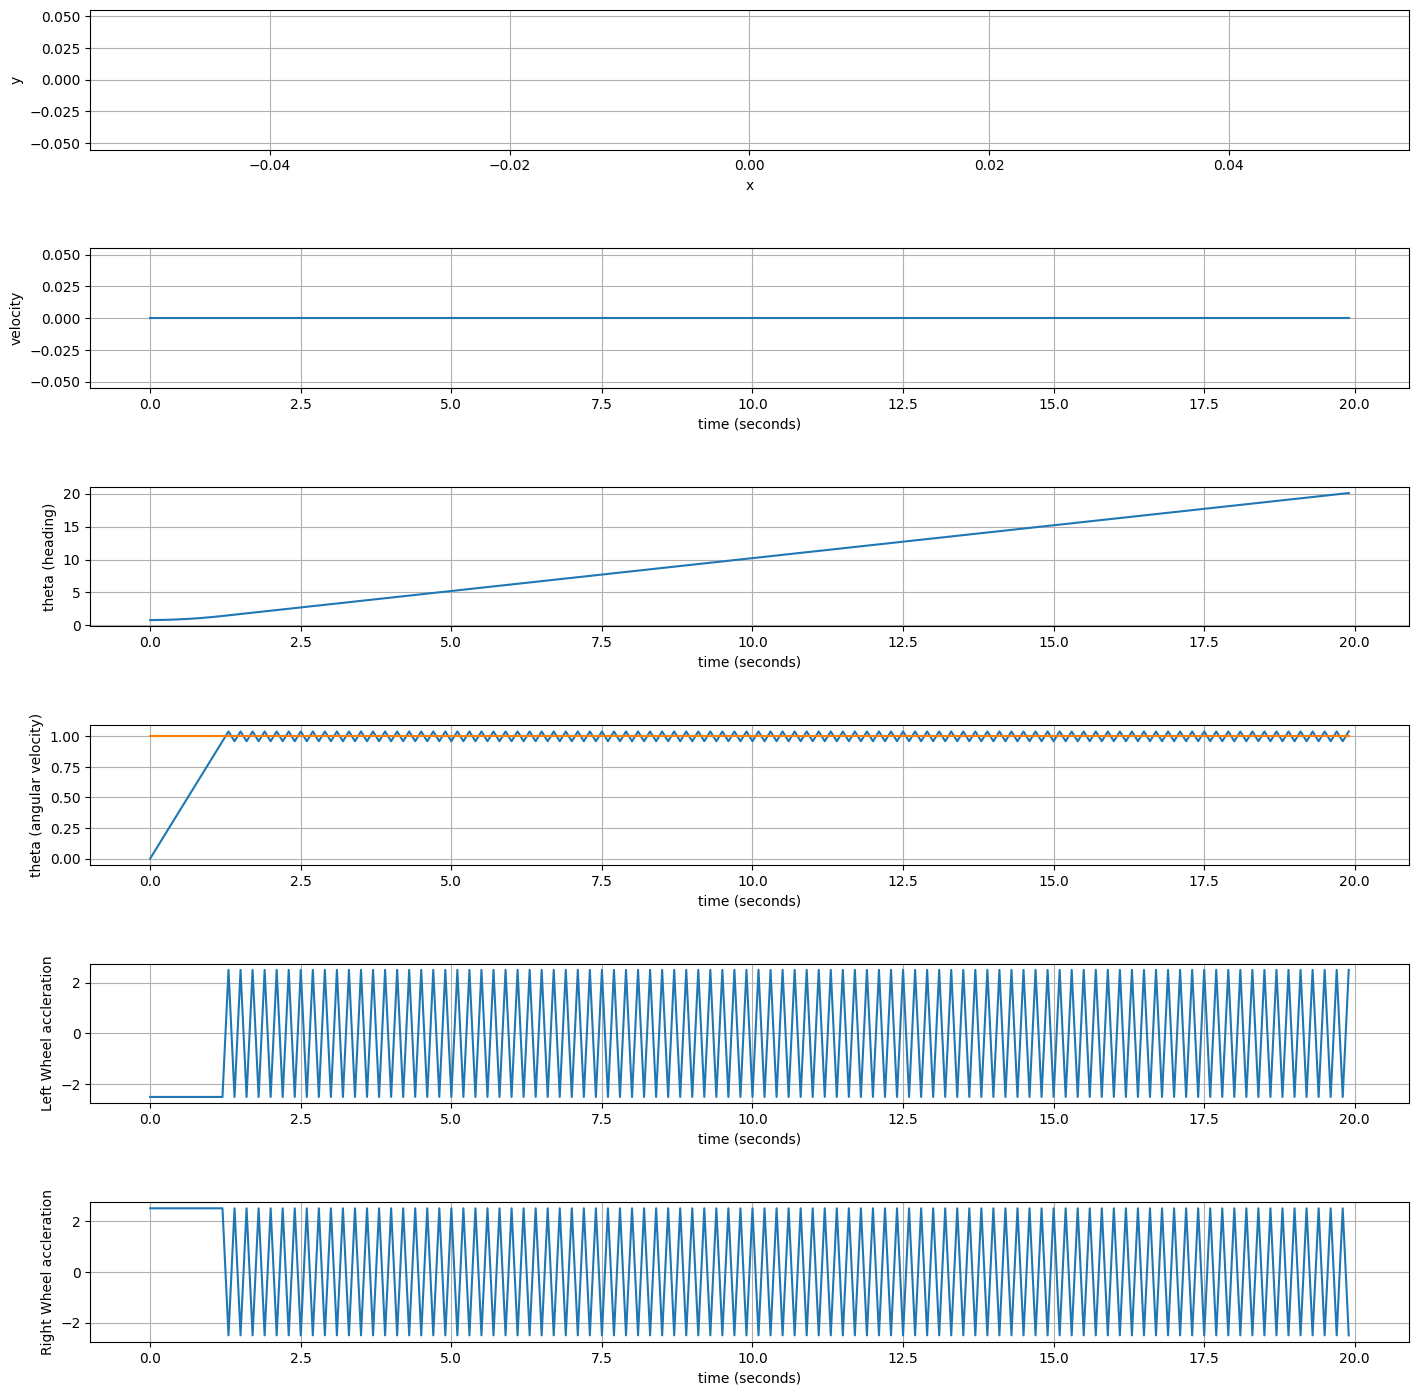

Percentage of overshoot: 4.00%
Ess (m): 0.04000000000000015
Peak time: 1.3 seconds


In [34]:
#EX: 2 
#Code purpose: To change the right and left wheel accelerations accordingly using a PID controller to reach a desired  angular velocity of 1
#Code for the estimation of the overshoot, the steady-state error and the estimation of the peak time is from HW #5 as well as the general code for the PID implementation

import math
import numpy as np
import matplotlib.pyplot as plt

r,b,t_0, x_k, y_k,w_k, v_k,y_list, x_list,time_list,v_list, heading, ang_vel_list ,t, t_f, dt, theta_k = set_variables_back()

ref_values = []
left_acceleration_values = []
right_acceleration_values = []

v_0 = 0 #meters/second
w_0 = 0 #mesters/second
dt = 0.1 # delta t 
 

acc_l = 0  #set to 0, since PID will control this 
acc_r = 0  #set to 0, since PID will control this
t_f = 20  #end time 

#left wheel PID controls
e_prev_l = 0 #for pid controls
e_int_l = 0 #for pid controls

#Right wheel PID controls
e_prev_r = 0 #for pid controls
e_int_r = 0 #for pid controls 

#PID #1 (Right wheel acceleration)
K_p1 = 500  #past 70
K_d1 = 20   #future
K_i1 = 20 #present
#PID #2 (Left wheel acceleration)
K_p2 = 500  #past 70
K_d2 = 20   #future
K_i2 = 20  #present

w_d = 1  #desired angular velocity
v_k = v_0 
w_k = w_0 #set the angular velocity to zero 

#setting up matrices for the solver
A = np.array([[r/2, r/2],       #matrix that holds the formula for velocity and angular velocity
            [r/(2*b),-1 * r/(2*b)]])

B = np.array([[acc_l],[acc_r]]) #matrix that holds the left and right acceleration 

v_w = np.array([[v_k],[w_k]])   #matrix that holds the values of the velocity and the angular velocity

#Calculated values from the solver 
max_acc_r = 2.5
max_acc_l = -2.5

while t < t_f:  #the discrete time format in code
    ref_values.append(w_d)
    
    #right wheel PID #1
    e_k_r = w_d - w_k #calculates error, reference minus the calculated angular velocity
    e_dot_r = (e_k_r - e_prev_r) /dt  
    e_prev_r = e_k_r 
    e_int_r += e_k_r* dt 
    acceleration_right = K_p2 * e_k_r + K_i2 * e_int_r + K_d2 * e_dot_r
    acc_r = saturate(acceleration_right, max_acc_r)
    right_acceleration_values.append(acc_r)
    
    #left wheel PID#2 
    e_k_l = w_d - w_k #calculates error
    e_dot_l = (e_k_l - e_prev_l) /dt  
    e_prev_l = e_k_l 
    e_int_l += e_k_l* dt 
    acceleration_left = K_p1 * e_k_l + K_i1 * e_int_l + K_d1 * e_dot_l
    acc_l = saturate(acceleration_left, max_acc_l)
    left_acceleration_values.append(acc_l)
    

    
    B[0] = acc_r #updating matrix with updated acceleration
    B[1] = acc_l #updating matrix with updated acceleration
    
    v_k = float((v_w[0]))  #takes the velocity from the matrix (float because had issue with it appending arrays instead of numeric values)
    w_k = float((v_w[1]))  #takes the angular velocity from the matrix and holds it as the angular velocity 
    v_list.append(v_k)  
    x_list.append(x_k)
    y_list.append(y_k)
    time_list.append(t)
    heading.append(theta_k)
    ang_vel_list.append(w_k)
    
    v_w1 = (A.dot(B) * dt) + v_w  #calculates the matrix for the time step
    v_w = v_w1 #sets up the matrix for the next time step
    v_k = float(v_w[0]) #translates the velocity to a numeric value to be used for the x,y,and theta calculations
    w_k = float(v_w[1]) #translates the angular velocity to a numeric value to be used for the x,y,and theta calculations
    theta_k1 = dt*(w_k) + theta_k  #calculates next heading
    theta_k = theta_k1  #sets up heading for the next time step
    x_k1 = dt*(math.cos(theta_k)*v_k)+x_k  #calculates next x-value
    x_k = x_k1  #sets up x for the next time step
    y_k1 = dt*(math.sin(theta_k)*v_k)+y_k  #calculates next y 
    y_k = y_k1 #sets up y for the next time step
    t += dt  #increments time 
    
fig, axs = plt.subplots(6, 1, figsize=(15, 15))
fig.tight_layout(pad=5.0)


axs[0].plot(x_list,y_list)
axs[0].set_xlabel('x')
axs[0].set_ylabel('y')
axs[0].grid()

axs[1].plot(time_list, v_list)
axs[1].set_xlabel('time (seconds)')
axs[1].set_ylabel('velocity')
axs[1].grid()

axs[2].plot(time_list, heading)
axs[2].set_xlabel('time (seconds)')
axs[2].set_ylabel('theta (heading)')
axs[2].grid()

axs[3].plot(time_list, ang_vel_list)
axs[3].plot(time_list, ref_values)
axs[3].set_xlabel('time (seconds)')
axs[3].set_ylabel('theta (angular velocity)')
axs[3].grid()

axs[4].plot(time_list, left_acceleration_values)
axs[4].set_xlabel('time (seconds)')
axs[4].set_ylabel('Left Wheel accleration')
axs[4].grid()

axs[5].plot(time_list, right_acceleration_values)
axs[5].set_xlabel('time (seconds)')
axs[5].set_ylabel('Right Wheel accleration')
axs[5].grid()


plt.show()

# estimate the overshoot
OS = (np.max(ang_vel_list)-w_d)/w_d*100
print('Percentage of overshoot:',format(OS,'.2f'),'\b%')

# estimate the steady-state error
e_ss = w_d - w_k
print('Ess (m):',e_ss)

# estimate the peak time
tp = np.argmax(ang_vel_list)*dt
print('Peak time:',tp,'seconds')



Explanation: Since the matrix is solved for an angular velocity of 1. The values that it gives back is 2.5, -2.5 for the right and left wheel respectively. This is used for the max values. The x and y don't move at all because there is no linear velocity. Once the system reaches an angular velocity of 1 instead of dropping down to zero they alternatively swap from -2.5 to 2.5 where each wheel is the opposite value of the other one. I believe that this is done to keep the DDR at an angular velocity of 1 so it continously cancels out. This is not ideal and will explored in the other examples.  

### EX: #3 w =1 (Setting left acceleration to 0)

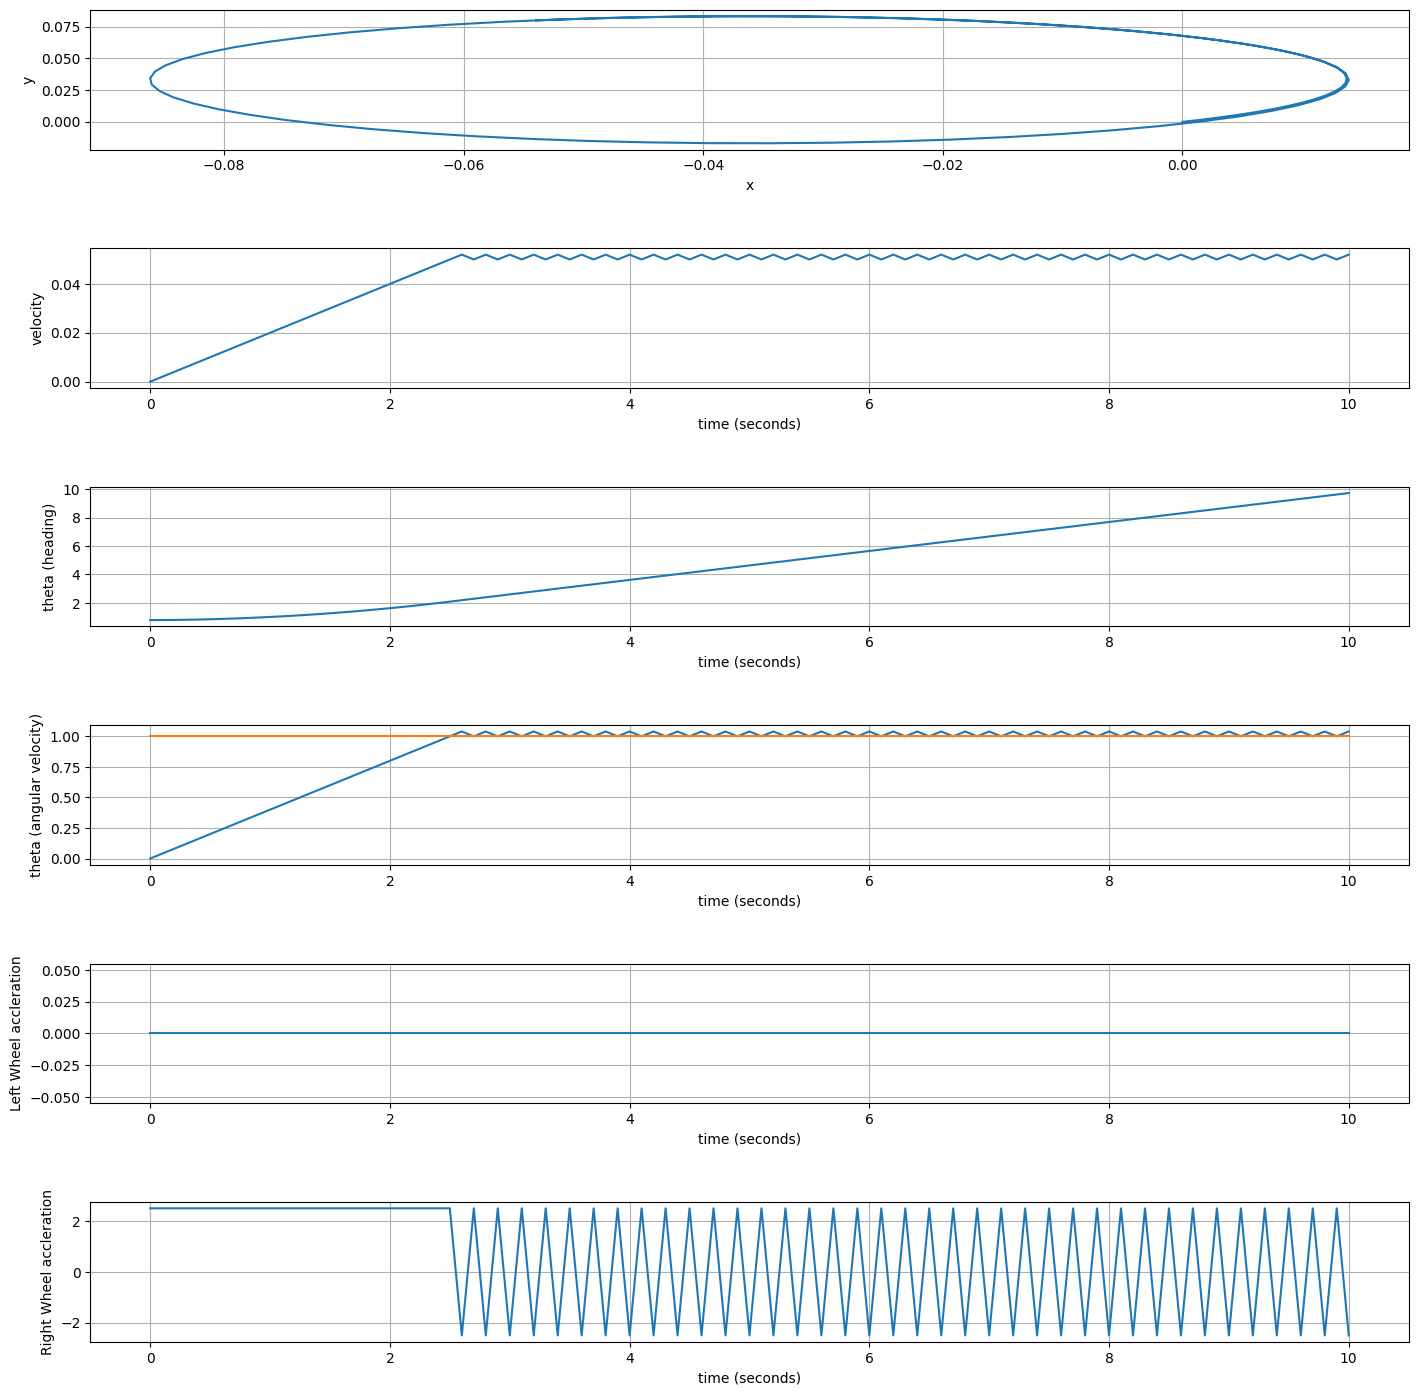

Percentage of overshoot: 4.00%
Ess (m): 0.95
Peak time: 2.6 seconds


In [35]:
#Code purpose: To change the right and left wheel accelerations accordingly using a PID controller to reach a desired  angular velocity of 1.
#Instead of doing a where the max values are 2.5, -2.5 for the right and left wheels respectively. Only the right wheel is activated in order to reach 
#target angular velocity. 
#Code for the estimation of the overshoot, the steady-state error and the estimation of the peak time is from HW #5 as well as the general code for the PID implementation

import math
import numpy as np
import matplotlib.pyplot as plt

r,b,t_0, x_k, y_k,w_k, v_k,y_list, x_list,time_list,v_list, heading, ang_vel_list ,t, t_f, dt, theta_k = set_variables_back()

ref_values = []
left_acceleration_values = []
right_acceleration_values = []

v_0 = 0 #meters/second
w_0 = 0 #mesters/second
dt = 0.1 # delta t 
 

acc_l = 0  #set to 0, since PID will control this 
acc_r = 0  #set to 0, since PID will control this
t_f = 10  #end time 

#left wheel PID controls
e_prev_l = 0 #for pid controls
e_int_l = 0 #for pid controls

#Right wheel PID controls
e_prev_r = 0 #for pid controls
e_int_r = 0 #for pid controls 

#PID #1
K_p1 = 200  #past 70
K_d1 = 20   #future
K_i1 = 10 #present
#PID #2
K_p2 = 200  #past 70
K_d2 = 20   #future
K_i2 = 10  #present

w_d = 1  #desired angular velocity

v_k = v_0 

w_k = w_0 #set the angular velocity to zero 

#setting up matrices for the solver
A = np.array([[r/2, r/2],  #matrix that holds the formula for velocity and angular velocity
            [r/(2*b),-1 * r/(2*b)]])

B = np.array([[acc_l],[acc_r]]) #matrix that holds the left and right acceleration 

v_w = np.array([[v_k],[w_k]])  #matrix that holds the values of the velocity and the angular velocity

#Values that would cause a positive angular velocity

max_acc_r = 2.5
max_acc_l = 0


while t < t_f:  #the discrete time format in code
    ref_values.append(w_d)
    
    
    #right wheel PID #1
    e_k_r = w_d - w_k #calculates error, reference minus the calculated angular velocity
    e_dot_r = (e_k_r - e_prev_r) /dt  
    e_prev_r = e_k_r 
    e_int_r += e_k_r* dt 
    acceleration_right = K_p2 * e_k_r + K_i2 * e_int_r + K_d2 * e_dot_r
    acc_r = saturate(acceleration_right, max_acc_r)
    right_acceleration_values.append(acc_r)
    
    #left wheel PID#2 
    e_k_l = w_d - w_k #calculates error
    e_dot_l = (e_k_l - e_prev_l) /dt  
    e_prev_l = e_k_l 
    e_int_l += e_k_l* dt 
    acceleration_left = K_p1 * e_k_l + K_i1 * e_int_l + K_d1 * e_dot_l
    acc_l = saturate(acceleration_left, max_acc_l)
    left_acceleration_values.append(acc_l)
    

    
    B[0] = acc_r #updating matrix with updated acceleration
    B[1] = acc_l #updating matrix with updated acceleration
    
    v_k = float((v_w[0]))  #takes the velocity from the matrix (float because had issue with it appending arrays instead of numeric values)
    w_k = float((v_w[1]))  #takes the angular velocity from the matrix and holds it as the angular velocity 
    v_list.append(v_k)  
    x_list.append(x_k)
    y_list.append(y_k)
    time_list.append(t)
    heading.append(theta_k)
    ang_vel_list.append(w_k)
    
    v_w1 = (A.dot(B) * dt) + v_w  #calculates the matrix for the time step
    v_w = v_w1 #sets up the matrix for the next time step
    v_k = float(v_w[0]) #translates the velocity to a numeric value to be used for the x,y,and theta calculations
    w_k = float(v_w[1]) #translates the angular velocity to a numeric value to be used for the x,y,and theta calculations
    theta_k1 = dt*(w_k) + theta_k  #calculates next heading
    theta_k = theta_k1  #sets up heading for the next time step
    x_k1 = dt*(math.cos(theta_k)*v_k)+x_k  #calculates next x-value
    x_k = x_k1  #sets up x for the next time step
    y_k1 = dt*(math.sin(theta_k)*v_k)+y_k  #calculates next y 
    y_k = y_k1 #sets up y for the next time step
    t += dt  #increments time 
    
fig, axs = plt.subplots(6, 1, figsize=(15, 15))
fig.tight_layout(pad=5.0)


axs[0].plot(x_list,y_list)
axs[0].set_xlabel('x')
axs[0].set_ylabel('y')
axs[0].grid()

axs[1].plot(time_list, v_list)
axs[1].set_xlabel('time (seconds)')
axs[1].set_ylabel('velocity')
axs[1].grid()

axs[2].plot(time_list, heading)
axs[2].set_xlabel('time (seconds)')
axs[2].set_ylabel('theta (heading)')
axs[2].grid()

axs[3].plot(time_list, ang_vel_list)
axs[3].plot(time_list, ref_values)
axs[3].set_xlabel('time (seconds)')
axs[3].set_ylabel('theta (angular velocity)')
axs[3].grid()

axs[4].plot(time_list, left_acceleration_values)
axs[4].set_xlabel('time (seconds)')
axs[4].set_ylabel('Left Wheel accleration')
axs[4].grid()

axs[5].plot(time_list, right_acceleration_values)
axs[5].set_xlabel('time (seconds)')
axs[5].set_ylabel('Right Wheel accleration')
axs[5].grid()


plt.show()

# estimate the overshoot
OS = (np.max(ang_vel_list)-w_d)/w_d*100
print('Percentage of overshoot:',format(OS,'.2f'),'\b%')

# estimate the steady-state error
e_ss = w_d - v_k
print('Ess (m):',e_ss)

# estimate the peak time
tp = np.argmax(ang_vel_list)*dt
print('Peak time:',tp,'seconds')



Explanation: Instead of using the solved matrix values, the left wheel acceleration max is set to 0 and the right wheel acceleration is set to 2.5. This will produce a positive angular velocity and then we can control the right wheel acceleration to reach a value of 1 for the angular velocity. Even with this one in order to keep at an angular velocity of 1 the right wheel acceleration oscillates. The heading increases in a positive direction which is what we want. The velocity increaes and so does the the position of x and y. I believe that is from the size of the DDR wheels so if it moves the wheels at all you are bound to get some sort of posotional movement which in turn would increase the velocity.  

### EX: #4 V = 1 , w = 1 (Using #2)

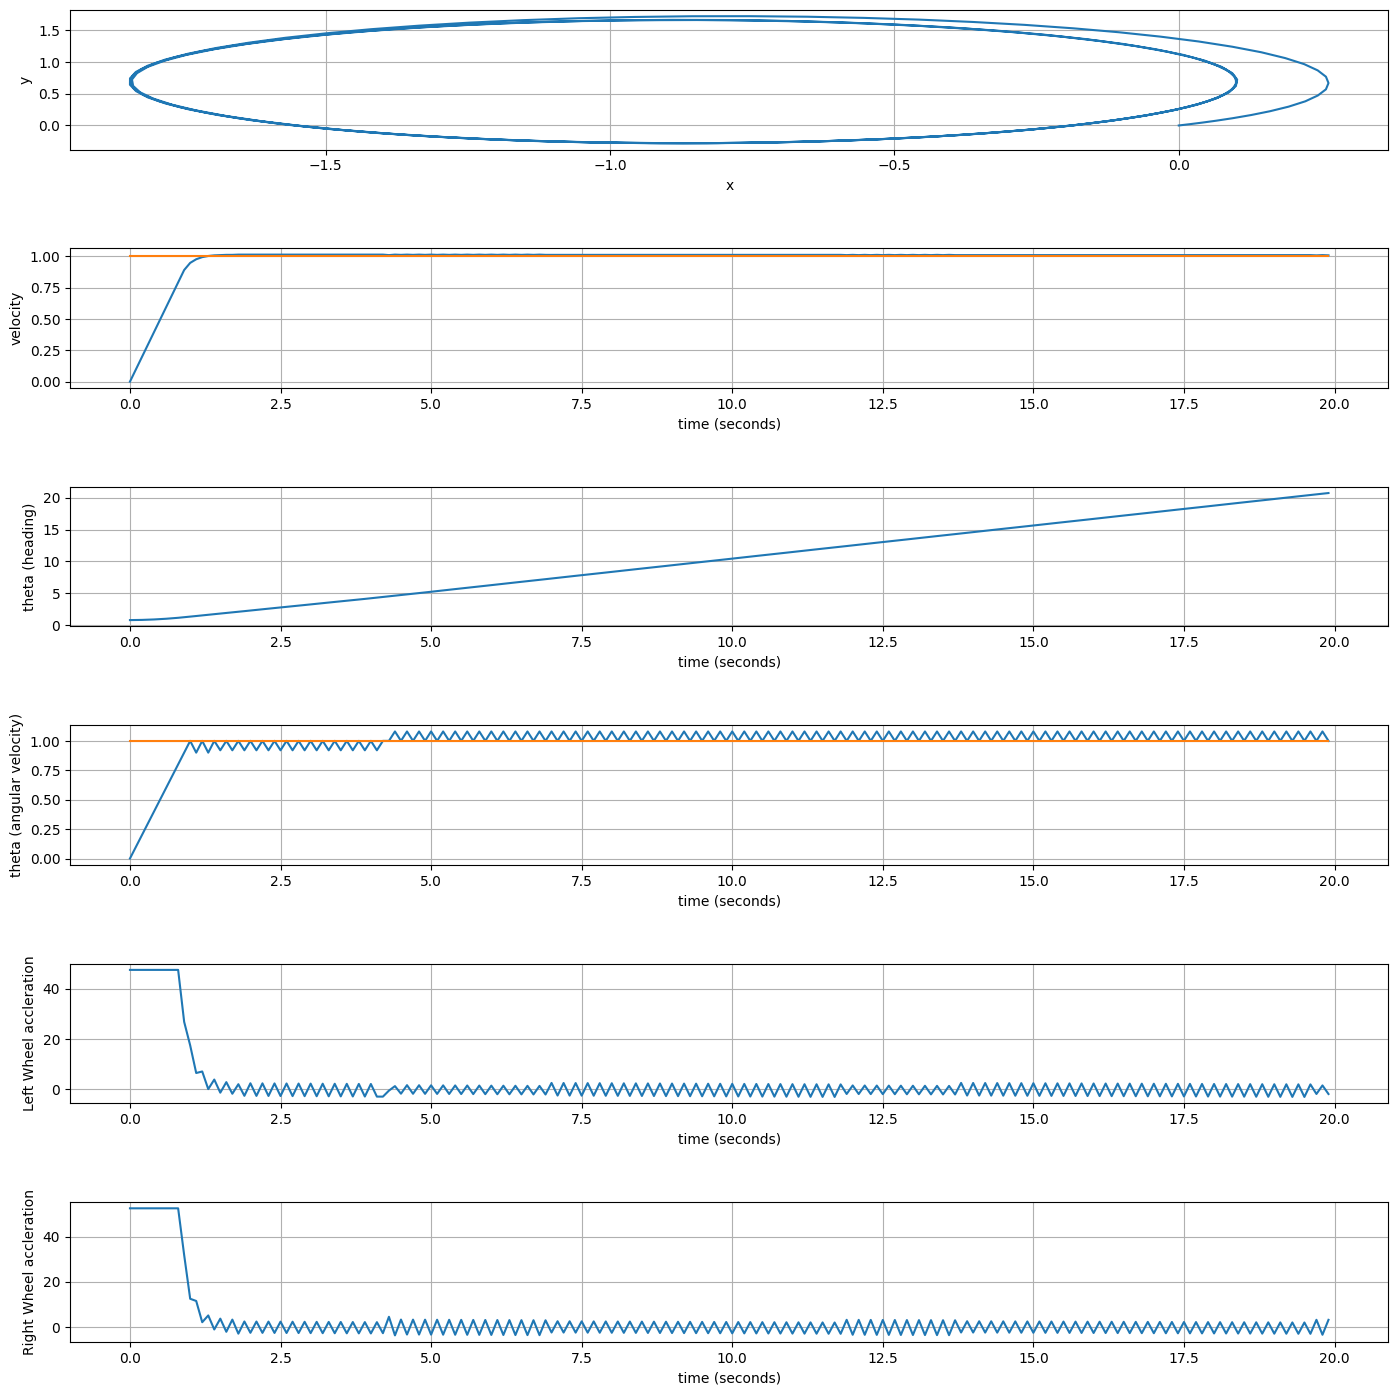

Percentage of overshoot (linear velocity): 1.40%
Ess (m) (linear velocity): -0.009999999999999787
Peak time (linear velocity): 1.8 seconds
Percentage of overshoot (angular linear velocity): 8.00%
Ess (m (Angular linear velocity)): -0.009999999999999787
Peak time (Angular linear velocity): 4.4 seconds


In [36]:
#Code purpose: To change the right and left wheel accelerations accordingly using a PID controller to reach a desired linear velocity of 1 and an angular velocity of 1 
#Code for the estimation of the overshoot, the steady-state error and the estimation of the peak time is from HW #5 as well as the general code for the PID implementation


import math
import numpy as np
import matplotlib.pyplot as plt

r,b,t_0, x_k, y_k,w_k, v_k,y_list, x_list,time_list,v_list, heading, ang_vel_list ,t, t_f, dt, theta_k = set_variables_back()

ref_values_L = []
ref_values_A = []
left_acceleration_values = []
right_acceleration_values = []

#setting up the numerical solution parameters
v_0 = 0 #meters/second 
dt = 0.1 # delta t 
max_acc_r_linear = 50
max_acc_l_linear = 50
max_acc_r_angular = 2.5
max_acc_l_angular = -2.5

acc_l = 0  #set to 0, since PID will control this 
acc_r = 0  #set to 0, since PID will control this
t_f = 20  #end time 

e_prev_l_linear = 0 #for pid controls
e_int_l_linear = 0 #for pid controls 
e_prev_l_angular = 0 #for pid controls
e_int_l_angular = 0 #for pid controls 

e_prev_r_linear = 0 #for pid controls
e_int_r_linear = 0 #for pid controls 
e_prev_r_angular = 0 #for pid controls
e_int_r_angular = 0 #for pid controls

#PID 1 Right Wheel linear
K_p1 = 400 #past 70
K_d1 = 20   #future
K_i1 = 10 #present

#PID 2 Right Wheel angular
K_p2 = 500 #past 70
K_d2 = 20   #future
K_i2 = 20 #present

#PID 3 Left Wheel linear
K_p3 = 400 #past 70
K_d3 = 20   #future
K_i3 = 10 #present

#PID 4 Left Wheel angular
K_p4 = 500 #past 70
K_d4 = 20   #future
K_i4 = 20 #present

v_k = v_0 
w_k = 0 
v_d = 1
w_d = 1

A = np.array([[r/2, r/2],  #matrix that holds the formula for velocity and angular velocity
            [r/(2*b),-1 * r/(2*b)]])

B = np.array([[acc_r],[acc_l]]) #matrix that holds the left and right acceleration 

v_w = np.array([[v_k],[w_k]])  #matrix that holds the values of the velocity and the angular velocity


while t < t_f:  #the discrete time format in code
    ref_values_L.append(v_d) #appending desired linear velocity
    ref_values_A.append(w_d) #appending desired angular velocity
    
    
    #right wheel linear  #1

    e_k_r_linear = v_d - v_k #calculates error, desired angular velocity minus current velocity
    e_dot_r_linear = (e_k_r_linear - e_prev_r_linear) /dt  
    e_prev_r_linear = e_k_r_linear 
    e_int_r_linear += e_k_r_linear * dt 
    acceleration_right_linear = K_p1 * e_k_r_linear + K_i1 * e_int_r_linear + K_d1 * e_dot_r_linear
    acc_r_linear = saturate(acceleration_right_linear, max_acc_r_linear)
    
    #right wheeel angular #2
    
    e_k_r_angular = w_d - w_k #calculates error, desired angular velocity minus current velocity
    e_dot_r_angular = (e_k_r_angular - e_prev_r_angular) /dt  
    e_prev_r_angular = e_k_r_angular 
    e_int_r_angular += e_k_r_angular * dt 
    acceleration_right_angular = K_p2 * e_k_r_angular + K_i2 * e_int_r_angular + K_d2 * e_dot_r_angular
    acc_r_angular = saturate(acceleration_right_angular, max_acc_r_angular)
    
    #left wheel linear #3

    e_k_l_linear = v_d - v_k #calculates error, desired angular velocity minus current velocity
    e_dot_l_linear = (e_k_l_linear - e_prev_l_linear) /dt  
    e_prev_l_linear = e_k_l_linear 
    e_int_l_linear += e_k_l_linear * dt 
    acceleration_left_linear = K_p3 * e_k_l_linear + K_i3 * e_int_l_linear + K_d3 * e_dot_l_linear
    acc_l_linear = saturate(acceleration_left_linear, max_acc_l_linear)
    
    #left wheeel angular #4
  
    e_k_l_angular = w_d - w_k #calculates error, desired angular velocity minus current velocity
    e_dot_l_angular = (e_k_l_angular - e_prev_l_angular) /dt  
    e_prev_l_angular = e_k_l_angular 
    e_int_l_angular += e_k_l_angular * dt 
    acceleration_left_angular = K_p4 * e_k_l_angular + K_i4 * e_int_l_angular + K_d4 * e_dot_l_angular
    acc_l_angular = saturate(acceleration_left_angular, max_acc_l_angular)
    
    acc_r = acc_r_linear + acc_r_angular
    acc_l = acc_l_linear + acc_l_angular
    
    right_acceleration_values.append(acc_r)
    left_acceleration_values.append(acc_l)
    
    B[0] = acc_r #updating matrix with updated acceleration
    B[1] = acc_l #updating matrix with updated acceleration
    

    v_k = float((v_w[0]))  #takes the velocity from the matrix (float because had issue with it appending arrays instead of numeric values)
    w_k = float((v_w[1]))  #takes the angular velocity from the matrix and holds it as the angular velocity 
    v_list.append(v_k)  
    x_list.append(x_k)
    y_list.append(y_k)
    time_list.append(t)
    heading.append(theta_k)
    ang_vel_list.append(w_k)
    
    v_w1 = (A.dot(B) * dt) + v_w  #calculates the matrix for the time step
    v_w = v_w1 #sets up the matrix for the next time step
    v_k = float(v_w[0]) #translates the velocity to a numeric value to be used for the x,y,and theta calculations
    w_k = float(v_w[1]) #translates the angular velocity to a numeric value to be used for the x,y,and theta calculations
    theta_k1 = dt*(w_k) + theta_k  #calculates next heading
    theta_k = theta_k1  #sets up heading for the next time step
    x_k1 = dt*(math.cos(theta_k)*v_k)+x_k  #calculates next x-value
    x_k = x_k1  #sets up x for the next time step
    y_k1 = dt*(math.sin(theta_k)*v_k)+y_k  #calculates next y 
    y_k = y_k1 #sets up y for the next time step
    t += dt  #increments time 
    
fig, axs = plt.subplots(6, 1, figsize=(15, 15))
fig.tight_layout(pad=5.0)



axs[0].plot(x_list,y_list)
axs[0].set_xlabel('x')
axs[0].set_ylabel('y')
axs[0].grid()

axs[1].plot(time_list, v_list)
axs[1].plot(time_list, ref_values_L)
axs[1].set_xlabel('time (seconds)')
axs[1].set_ylabel('velocity')
axs[1].grid()

axs[2].plot(time_list, heading)
axs[2].set_xlabel('time (seconds)')
axs[2].set_ylabel('theta (heading)')
axs[2].grid()

axs[3].plot(time_list, ang_vel_list)
axs[3].plot(time_list, ref_values_A)
axs[3].set_xlabel('time (seconds)')
axs[3].set_ylabel('theta (angular velocity)')
axs[3].grid()

axs[4].plot(time_list, left_acceleration_values)
axs[4].set_xlabel('time (seconds)')
axs[4].set_ylabel('Left Wheel accleration')
axs[4].grid()

axs[5].plot(time_list, right_acceleration_values)

axs[5].set_xlabel('time (seconds)')
axs[5].set_ylabel('Right Wheel accleration')
axs[5].grid()


plt.show()

# estimate the linear velocity overshoot
OS = (np.max(v_list)-v_d)/v_d*100
print('Percentage of overshoot (linear velocity):',format(OS,'.2f'),'\b%')

# estimate the steady-state error for linear velocity
e_ss = v_d - v_k
print('Ess (m) (linear velocity):',e_ss)

# estimate the peak time for linear velocity 
tp = np.argmax(v_list)*dt
print('Peak time (linear velocity):',tp,'seconds')

# estimate the angular linear overshoot
OS = (np.max(ang_vel_list)-w_d)/w_d*100
print('Percentage of overshoot (angular linear velocity):',format(OS,'.2f'),'\b%')

# estimate the angular velocity steady-state error
e_ss = w_d - v_k
print('Ess (m (Angular linear velocity)):',e_ss)

# estimate the peak time for angular velocity
tp = np.argmax(ang_vel_list)*dt
print('Peak time (Angular linear velocity):',tp,'seconds')



Explanation: When we solve the matrix for a desired velocity and angular velocity of 1. We get the value 52.5 for the right wheel acceleration and 47.5 for the left wheel acceleration. From the math from solving the matrix, we know that we can break it up and add the result of the PIDs together in order to get that time steps current right and left wheel acceleration. This does mean that we need four PIDs. From the plots we can see that the model attempts to control the velocity but since we used the max values for the angular velocity of 2.5, -2,5 for the left and right wheel acceleration respectively. We can expect some osciallations in the wheel accelerations. We do have a pretty high overshoot for the angular velocity and I think this is just from the oscialating left and right wheel acceleration.    

### EX: #5 V = 1 , w = 1 (Using #3)

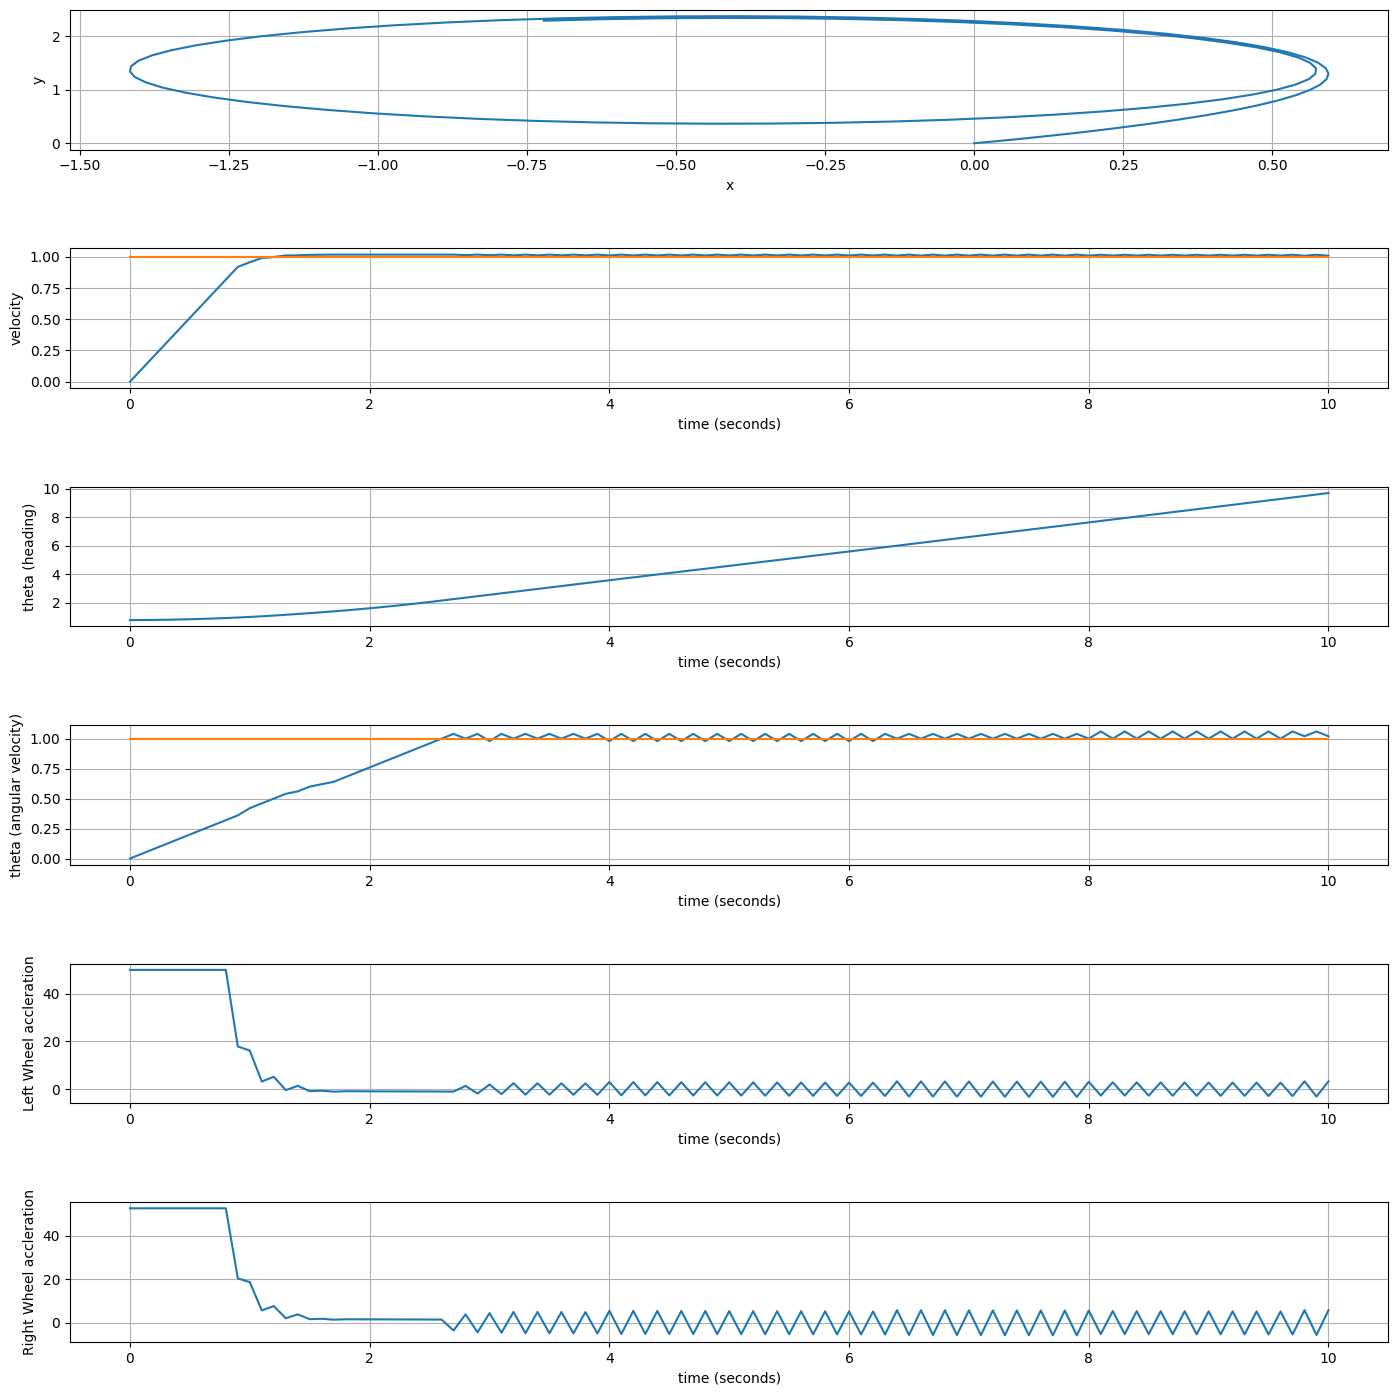

Percentage of overshoot (linear velocity): 1.60%
Ess (m) (linear velocity): -0.014999999999999458
Peak time (linear velocity): 1.7000000000000002 seconds
Percentage of overshoot (angular linear velocity): 6.00%
Ess (m (Angular linear velocity)): -0.014999999999999458
Peak time (Angular linear velocity): 8.1 seconds


In [38]:
#Code purpose: To change the right and left wheel accelerations accordingly using a PID controller to reach a desired linear velocity of 1 and an angular velocity of 1 
#using a 0 for left and 2.5 for the right to get a positive angular velocity. 
#Code for the estimation of the overshoot, the steady-state error and the estimation of the peak time is from HW #5 as well as the general code for the PID implementation



import math
import numpy as np
import matplotlib.pyplot as plt

r,b,t_0, x_k, y_k,w_k, v_k,y_list, x_list,time_list,v_list, heading, ang_vel_list ,t, t_f, dt, theta_k = set_variables_back()

ref_values_L = []
ref_values_A = []
left_acceleration_values = []
right_acceleration_values = []

#setting up the numerical solution parameters
v_0 = 0 #meters/second 
dt = 0.1 # delta t 
max_acc_r_linear = 50
max_acc_l_linear = 50
max_acc_r_angular = 2.5
max_acc_l_angular = 0

acc_l = 0  #set to 0, since PID will control this 
acc_r = 0  #set to 0, since PID will control this
t_f = 10  #end time 

e_prev_l_linear = 0 #for pid controls
e_int_l_linear = 0 #for pid controls 
e_prev_l_angular = 0 #for pid controls
e_int_l_angular = 0 #for pid controls 

e_prev_r_linear = 0 #for pid controls
e_int_r_linear = 0 #for pid controls 
e_prev_r_angular = 0 #for pid controls
e_int_r_angular = 0 #for pid controls

#PID 1 Right Wheel Linear
K_p1 = 400 #past 70
K_d1 = 20   #future
K_i1 = 10 #present

#PID 2 Right Wheel Angular
K_p2 = 200 #past 70
K_d2 = 20   #future
K_i2 = 10 #present

#PID 3 Left Wheel Linear
K_p3 = 400 #past 70
K_d3 = 20   #future
K_i3 = 10 #present

#PID 4 Right Wheel Angular
K_p4 = 200 #past 70
K_d4 = 20   #future
K_i4 = 10 #present

v_k = v_0 
w_k = 0 #set the angular velocity to zero 
v_d = 1
w_d = 1

A = np.array([[r/2, r/2],  #matrix that holds the formula for velocity and angular velocity
            [r/(2*b),-1 * r/(2*b)]])

B = np.array([[acc_r],[acc_l]]) #matrix that holds the left and right acceleration 

v_w = np.array([[v_k],[w_k]])  #matrix that holds the values of the velocity and the angular velocity


while t < t_f:  #the discrete time format in code
    ref_values_L.append(v_d) #appending desired linear velocity
    ref_values_A.append(w_d) #appending desired angular velocity
    
    
    #right wheel linear  #1

    e_k_r_linear = v_d - v_k #calculates error, desired angular velocity minus current velocity
    e_dot_r_linear = (e_k_r_linear - e_prev_r_linear) /dt  
    e_prev_r_linear = e_k_r_linear 
    e_int_r_linear += e_k_r_linear * dt 
    acceleration_right_linear = K_p1 * e_k_r_linear + K_i1 * e_int_r_linear + K_d1 * e_dot_r_linear
    acc_r_linear = saturate(acceleration_right_linear, max_acc_r_linear)
    
    #right wheeel angular #2
    
    e_k_r_angular = w_d - w_k #calculates error, desired angular velocity minus current velocity
    e_dot_r_angular = (e_k_r_angular - e_prev_r_angular) /dt  
    e_prev_r_angular = e_k_r_angular 
    e_int_r_angular += e_k_r_angular * dt 
    acceleration_right_angular = K_p2 * e_k_r_angular + K_i2 * e_int_r_angular + K_d2 * e_dot_r_angular
    acc_r_angular = saturate(acceleration_right_angular, max_acc_r_angular)
    
    #left wheel linear #3

    e_k_l_linear = v_d - v_k #calculates error, desired angular velocity minus current velocity
    e_dot_l_linear = (e_k_l_linear - e_prev_l_linear) /dt  
    e_prev_l_linear = e_k_l_linear 
    e_int_l_linear += e_k_l_linear * dt 
    acceleration_left_linear = K_p3 * e_k_l_linear + K_i3 * e_int_l_linear + K_d3 * e_dot_l_linear
    acc_l_linear = saturate(acceleration_left_linear, max_acc_l_linear)
    
    #left wheeel angular #4
  
    e_k_l_angular = w_d - w_k #calculates error, desired angular velocity minus current velocity
    e_dot_l_angular = (e_k_l_angular - e_prev_l_angular) /dt  
    e_prev_l_angular = e_k_l_angular 
    e_int_l_angular += e_k_l_angular * dt 
    acceleration_left_angular = K_p4 * e_k_l_angular + K_i4 * e_int_l_angular + K_d4 * e_dot_l_angular
    acc_l_angular = saturate(acceleration_left_angular, max_acc_l_angular)
    
    acc_r = acc_r_linear + acc_r_angular
    acc_l = acc_l_linear + acc_l_angular
    
    right_acceleration_values.append(acc_r)
    left_acceleration_values.append(acc_l)
    
    B[0] = acc_r #updating matrix with updated acceleration
    B[1] = acc_l #updating matrix with updated acceleration
    

    v_k = float((v_w[0]))  #takes the velocity from the matrix (float because had issue with it appending arrays instead of numeric values)
    w_k = float((v_w[1]))  #takes the angular velocity from the matrix and holds it as the angular velocity 
    v_list.append(v_k)  
    x_list.append(x_k)
    y_list.append(y_k)
    time_list.append(t)
    heading.append(theta_k)
    ang_vel_list.append(w_k)
    
    v_w1 = (A.dot(B) * dt) + v_w  #calculates the matrix for the time step
    v_w = v_w1 #sets up the matrix for the next time step
    v_k = float(v_w[0]) #translates the velocity to a numeric value to be used for the x,y,and theta calculations
    w_k = float(v_w[1]) #translates the angular velocity to a numeric value to be used for the x,y,and theta calculations
    theta_k1 = dt*(w_k) + theta_k  #calculates next heading
    theta_k = theta_k1  #sets up heading for the next time step
    x_k1 = dt*(math.cos(theta_k)*v_k)+x_k  #calculates next x-value
    x_k = x_k1  #sets up x for the next time step
    y_k1 = dt*(math.sin(theta_k)*v_k)+y_k  #calculates next y 
    y_k = y_k1 #sets up y for the next time step
    t += dt  #increments time 
    
fig, axs = plt.subplots(6, 1, figsize=(15, 15))
fig.tight_layout(pad=5.0)



axs[0].plot(x_list,y_list)
axs[0].set_xlabel('x')
axs[0].set_ylabel('y')
axs[0].grid()

axs[1].plot(time_list, v_list)
axs[1].plot(time_list, ref_values_L)
axs[1].set_xlabel('time (seconds)')
axs[1].set_ylabel('velocity')
axs[1].grid()

axs[2].plot(time_list, heading)
axs[2].set_xlabel('time (seconds)')
axs[2].set_ylabel('theta (heading)')
axs[2].grid()

axs[3].plot(time_list, ang_vel_list)
axs[3].plot(time_list, ref_values_A)
axs[3].set_xlabel('time (seconds)')
axs[3].set_ylabel('theta (angular velocity)')
axs[3].grid()

axs[4].plot(time_list, left_acceleration_values)
axs[4].set_xlabel('time (seconds)')
axs[4].set_ylabel('Left Wheel accleration')
axs[4].grid()

axs[5].plot(time_list, right_acceleration_values)
axs[5].set_xlabel('time (seconds)')
axs[5].set_ylabel('Right Wheel accleration')
axs[5].grid()


plt.show()

# estimate the linear velocity overshoot
OS = (np.max(v_list)-v_d)/v_d*100
print('Percentage of overshoot (linear velocity):',format(OS,'.2f'),'\b%')

# estimate the steady-state error for linear velocity
e_ss = v_d - v_k
print('Ess (m) (linear velocity):',e_ss)

# estimate the peak time for linear velocity 
tp = np.argmax(v_list)*dt
print('Peak time (linear velocity):',tp,'seconds')

# estimate the angular linear overshoot
OS = (np.max(ang_vel_list)-w_d)/w_d*100
print('Percentage of overshoot (angular linear velocity):',format(OS,'.2f'),'\b%')

# estimate the angular velocity steady-state error
e_ss = w_d - v_k
print('Ess (m (Angular linear velocity)):',e_ss)

# estimate the peak time for angular velocity
tp = np.argmax(ang_vel_list)*dt
print('Peak time (Angular linear velocity):',tp,'seconds')



Explanation: We can see that when we instead of using the matrix solved values for the max values we do get a bit of a better looking plot. We still get pretty big oscillations for the left and right wheel which in turn will cause the angular velocity to also have oscillations. We do also get a smaller percentage overshoot for the angular linear velocity. The positional movement from this plot matches up pretty close to the positional movement of the other plot where we try and control the angular and linear velocity to be 1. I do wonder if the doing it like this causes some sort of noise or disturbance between the variables as the model reaches the desired velocity first and then reaches the angular velocity next, that if reaching the velocity first causes the left and right wheel acceleration to change causing a change in the way the DDR would try and reach the angular velocity. 

## MPC controller examples
4 Examples: 
(where V is the desired velocity and W  is the desired angular velocity)

* EX #1 : V = 1
* EX #2 : W = 1
* EX #3 : V = -1
* EX #4 : W = -1

### EX #1: V = 1

Model defined!
MPC solver defined!


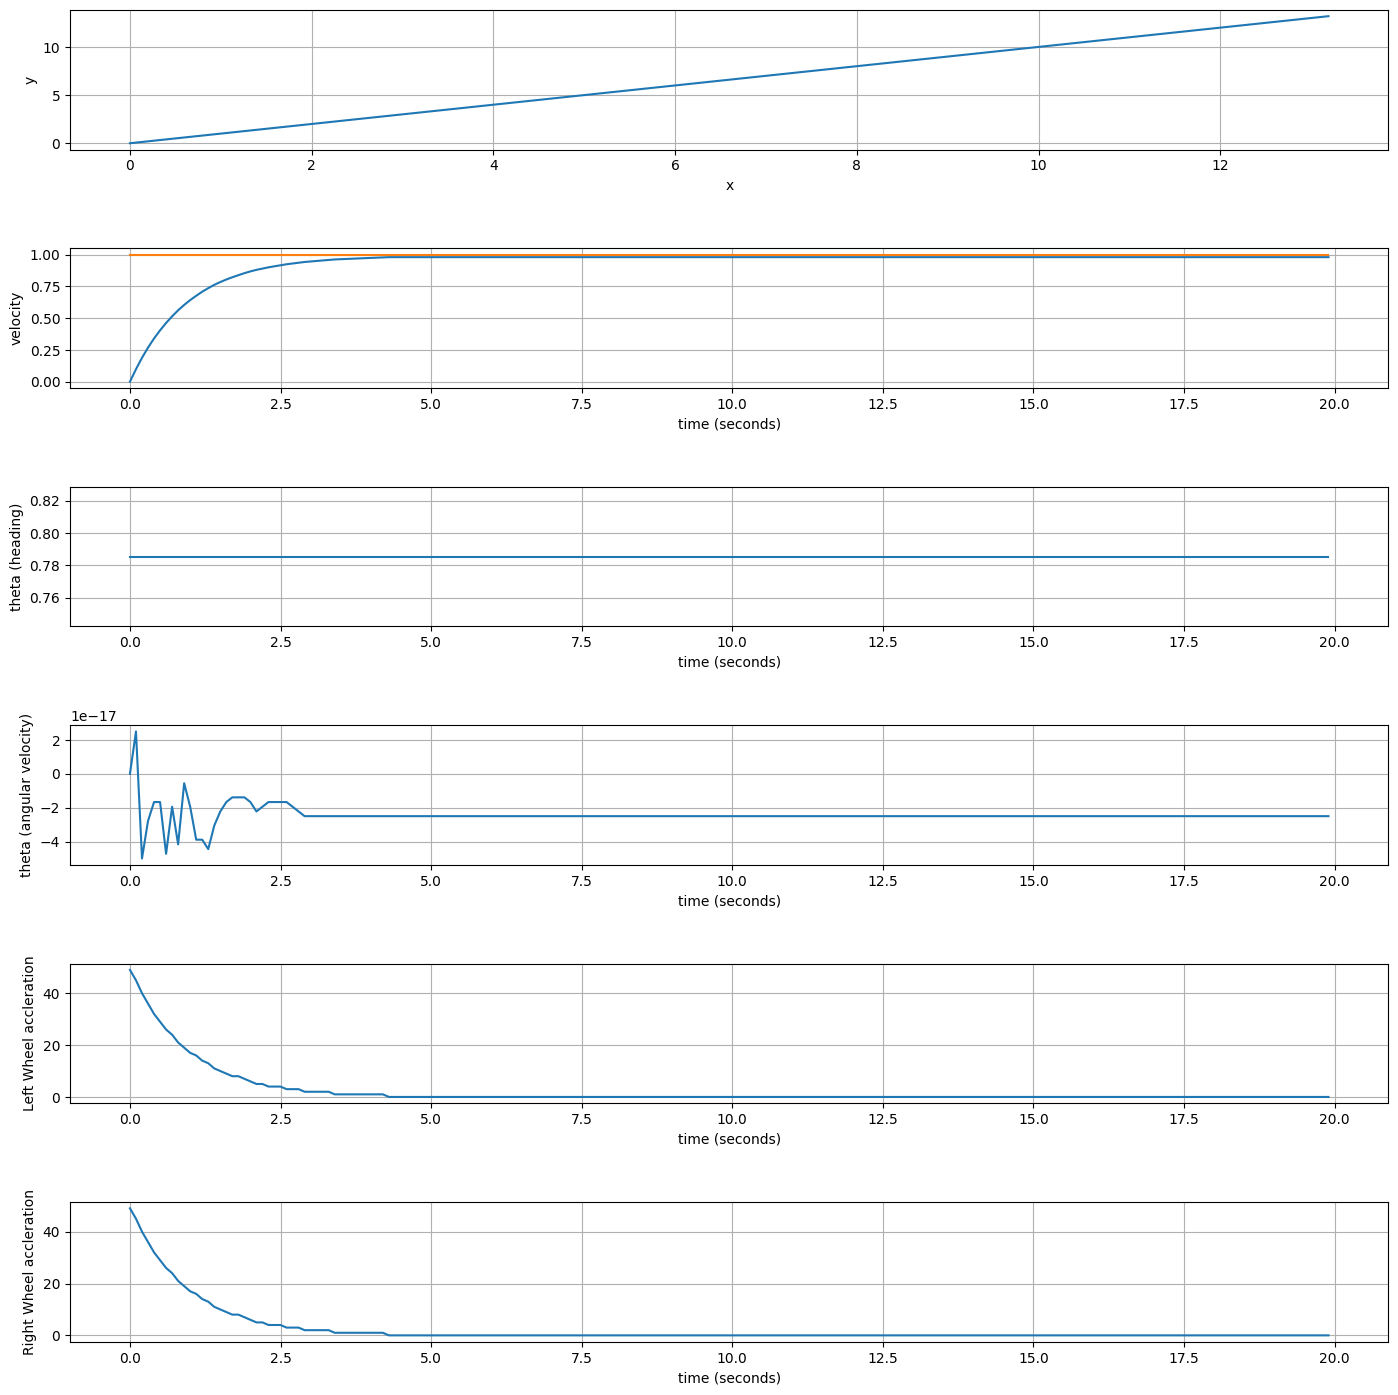

Percentage of overshoot (linear velocity): -2.00%
Ess (m) (linear velocity): 0.019999999999999574
Peak time (linear velocity): 4.3 seconds


In [39]:
#Description: This MPC aims to model the DDR to reach a linear velocity of 1 through finding the correct left and right wheel accelerations
#Source: This code takes code from the csc-340-MPC.ipynb, but is adapted to our model
#Source: The code for the overshoot, steady state error, and peak time come from HW5
r,b,t_0, x_k, y_k,w_k, v_k,y_list, x_list,time_list,v_list, heading, ang_vel_list ,t, t_f, dt, theta_k = set_variables_back()

left_acceleration_values = []
right_acceleration_values = []
ref_values = []

v_d = 1 
accel_r_max = 50
accel_l_max = 50

dt = 0.1 # delta t = 0.1 second

x_0 =  0 
v_0 =  0 


r = 0.02  #radius of the wheel in meters
b = 0.05  #length of half of axle, in meters
t_0 = 0  #starting time 
t_f = 20  #ending time 
dt = 0.1 #time increment 
x_k =0   #original x value, 0 
y_k =0  #original y value, 0 

w_k = 0  #angular velocity
v_k = 0  #velocity

acc_l = 0  #acceleration of the left wheel 
acc_r = 0  #acceleration of the right wheel
theta_k = math.pi/4  #heading of the robot, set to pi/4 becuase of diagram wanted it to be easy to visualize 
y_list = []  #initializing y list
x_list = []  #initializing x list
time_list = []  #initializing time list
v_list=[]  #intializing velocity list 
heading = []  #intialiing heading 
ang_vel_list = []  #intializing angular velocity list
t = t_0 #setting t to the start poistion

A = np.array([[r/2, r/2],
            [r/(2*b),-1 * r/(2*b)]])

B = np.array([[acc_l],[acc_r]])

v_w = np.array([[v_k],[w_k]])



############ MPC setup
# setting up the MPC solver
model_type = 'discrete' # either 'discrete' or 'continuous'
model = do_mpc.model.Model(model_type)
# define the states
v_lin = model.set_variable(var_type='_x', var_name='v_lin', shape=(1,1))
v_ang = model.set_variable(var_type='_x', var_name='v_ang', shape=(1,1))

# define the inputs
accel_l = model.set_variable(var_type='_u', var_name='accel_l')
accel_r = model.set_variable(var_type='_u', var_name='accel_r')
# setup the control goals
# avoid large forces
model.set_expression( expr_name="lagrange_term", expr= 0.00001* accel_l **2+ 0.00001* accel_r **2 )

# reach the final destinatioin (x_d) and stop
model.set_expression(
    expr_name="meyer_term", expr= 1000*(v_d - v_lin) ** 2+ 1* v_lin**2 
)
# include the dynamics in the model
model.set_rhs("v_lin", ((((accel_l * r)/2) + ((accel_r * r)/2))*dt + v_lin))
model.set_rhs("v_ang", ((((accel_l * r)/2) + ((accel_r * r)/2))*dt + v_ang))

# finish the setup
model.setup()
print('Model defined!')

# set up the MPC solver
mpc = do_mpc.controller.MPC(model)
mpc.settings.n_horizon = 10 # predict the next N steps
mpc.settings.t_step = dt 

lterm = model.aux["lagrange_term"]
mterm = model.aux["meyer_term"]

mpc.set_objective(lterm=lterm, mterm=mterm)
mpc.set_rterm(accel_l=0)
mpc.set_rterm(accel_r=0)

mpc.scaling['_x', 'v_lin'] = 1
mpc.scaling['_x', 'v_ang'] = 1

mpc.bounds["lower", "_u", "accel_l"] = -accel_l_max
mpc.bounds["upper", "_u", "accel_l"] = accel_l_max
              
mpc.bounds["lower", "_u", "accel_r"] = -accel_r_max
mpc.bounds["upper", "_u", "accel_r"] = accel_r_max
              
surpress_ipopt = {'ipopt.print_level':0, 'ipopt.sb': 'yes', 'print_time':0}
mpc.set_param(nlpsol_opts = surpress_ipopt)
mpc.setup()
print('MPC solver defined!')

# simulate the system
while t < t_f:
    ref_values.append(v_d)
    # set the solver for the current iteration    
    mpc.x0 = v_w
    mpc.set_initial_guess()
    u_opt = mpc.make_step(v_w) # find the optimal input
    
    B[0] = u_opt[0]
    B[1] = u_opt[1]
    
    right_acceleration_values.append(float(B[0]))
    left_acceleration_values.append(float(B[1]))
    
    v_list.append(v_k)
    x_list.append(x_k)
    y_list.append(y_k)
    time_list.append(t)
    heading.append(theta_k)
    ang_vel_list.append(w_k)
    
    v_w1 = (A.dot(B) * dt) + v_w
    v_w = v_w1
    v_k = float(v_w[0])
    w_k = float(v_w[1])
    
    theta_k1 = dt*(w_k) + theta_k
    theta_k = theta_k1
    x_k1 = dt*(math.cos(theta_k)*v_k)+x_k
    x_k = x_k1
    y_k1 = dt*(math.sin(theta_k)*v_k)+y_k
    y_k = y_k1
    t += dt
    


fig, axs = plt.subplots(6, 1, figsize=(15, 15))
fig.tight_layout(pad=5.0)


axs[0].plot(x_list,y_list)
axs[0].set_xlabel('x')
axs[0].set_ylabel('y')
axs[0].grid()

axs[1].plot(time_list, v_list)
axs[1].plot(time_list, ref_values)
axs[1].set_xlabel('time (seconds)')
axs[1].set_ylabel('velocity')
axs[1].grid()

axs[2].plot(time_list, heading)
axs[2].set_xlabel('time (seconds)')
axs[2].set_ylabel('theta (heading)')
axs[2].grid()

axs[3].plot(time_list, ang_vel_list)
axs[3].set_xlabel('time (seconds)')
axs[3].set_ylabel('theta (angular velocity)')
axs[3].grid()

axs[4].plot(time_list, left_acceleration_values)
axs[4].set_xlabel('time (seconds)')
axs[4].set_ylabel('Left Wheel accleration')
axs[4].grid()

axs[5].plot(time_list, right_acceleration_values)
axs[5].set_xlabel('time (seconds)')
axs[5].set_ylabel('Right Wheel accleration')
axs[5].grid()


    
plt.show()
              
# estimate the linear velocity overshoot
OS = (np.max(v_list)-v_d)/v_d*100
print('Percentage of overshoot (linear velocity):',format(OS,'.2f'),'\b%')

# estimate the steady-state error for linear velocity
e_ss = v_d - v_k
print('Ess (m) (linear velocity):',e_ss)

# estimate the peak time for linear velocity 
tp = np.argmax(v_list)*dt
print('Peak time (linear velocity):',tp,'seconds')


Explanation: This MPC mimicks the plots that can be seen from the PID equivalent, although this MPC appears to create smoother and more consistent plots. As the velocity reaches 1 the right and left wheel acceleration cuts out and velocity stays very close to 1. This one although has a negative overshoot while the PID has a positive overshoot. It also therefore has a different peak time. Although the plots from this compared to the PID plots are extremely similar which is to be expected. 

### EX #2: W = 1

Model defined!
MPC solver defined!


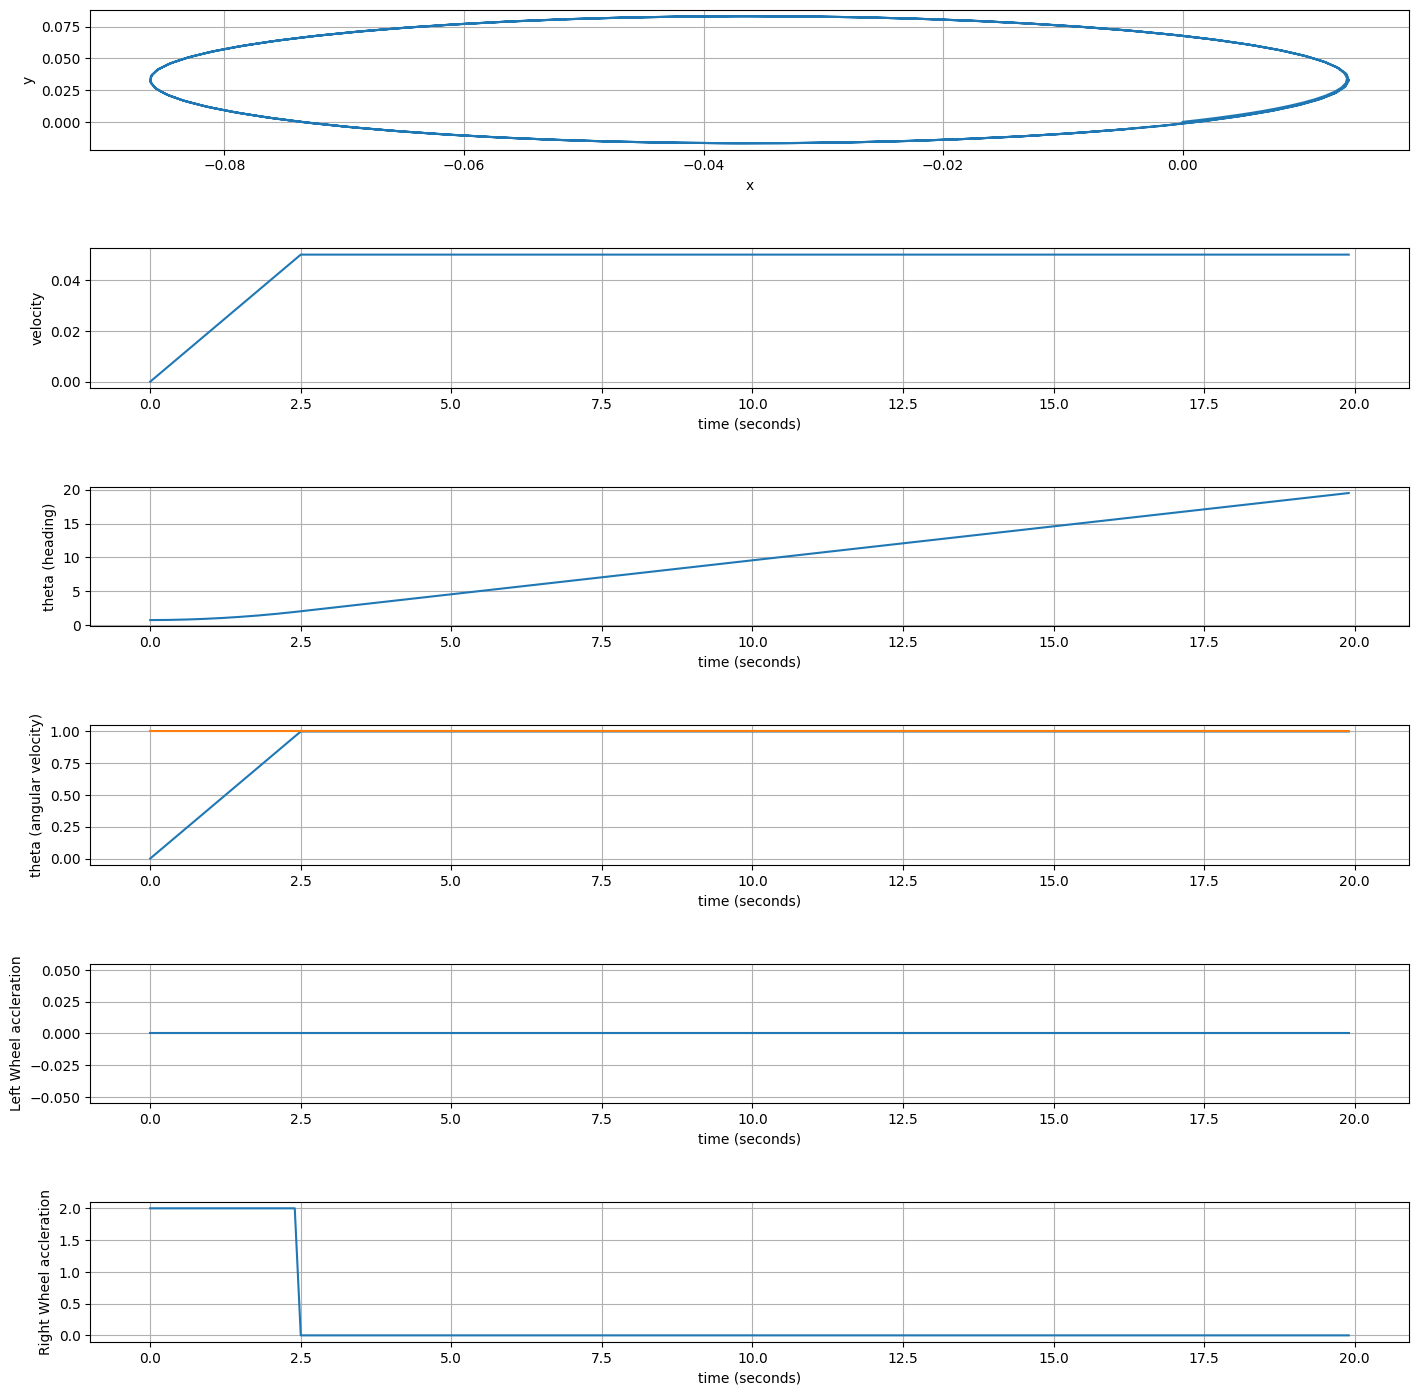

Percentage of overshoot (angular linear velocity): 0.00%
Ess (m (Angular linear velocity)): 0.95
Peak time (Angular linear velocity): 2.5 seconds


In [40]:
#Description: This MPC aims to model the DDR to reach an  angular velocity of 1 through finding the correct left and right wheel accelerations
#Source: This code takes code from the csc-340-MPC.ipynb, but is adapted to our model
#Source: The code for the overshoot, steady state error, and peak time come from HW5
r,b,t_0, x_k, y_k,w_k, v_k,y_list, x_list,time_list,v_list, heading, ang_vel_list ,t, t_f, dt, theta_k = set_variables_back()

left_acceleration_values = []
right_acceleration_values = []
ref_values = []

w_d = 1 
accel_r_max =  0
accel_l_max =  2.5

dt = 0.1 # delta t = 0.1 second

x_0 =  0 
v_0 =  0 


r = 0.02  #radius of the wheel in meters
b = 0.05  #length of half of axle, in meters
t_0 = 0  #starting time 
t_f = 20  #ending time 
dt = 0.1 #time increment 
x_k =0   #original x value, 0 
y_k =0  #original y value, 0 

w_k = 0  #angular velocity
v_k = 0  #velocity

acc_l = 0  #acceleration of the left wheel 
acc_r = 0  #acceleration of the right wheel
theta_k = math.pi/4  #heading of the robot, set to pi/4 becuase of diagram wanted it to be easy to visualize 
y_list = []  #initializing y list
x_list = []  #initializing x list
time_list = []  #initializing time list
v_list=[]  #intializing velocity list 
heading = []  #intialiing heading 
ang_vel_list = []  #intializing angular velocity list
t = t_0 #setting t to the start poistion

A = np.array([[r/2, r/2],
            [r/(2*b),-1 * r/(2*b)]])

B = np.array([[acc_l],[acc_r]])

v_w = np.array([[v_k],[w_k]])



############ MPC setup
# setting up the MPC solver
model_type = 'discrete' # either 'discrete' or 'continuous'
model = do_mpc.model.Model(model_type)
# define the states
v_lin = model.set_variable(var_type='_x', var_name='v_lin', shape=(1,1))
v_ang = model.set_variable(var_type='_x', var_name='v_ang', shape=(1,1))

# define the inputs
accel_l = model.set_variable(var_type='_u', var_name='accel_l')
accel_r = model.set_variable(var_type='_u', var_name='accel_r')
# setup the control goals
# avoid large forces
model.set_expression( expr_name="lagrange_term", expr= 0.00001* accel_l **2+ 0.00001* accel_r **2 )

# reach the final destinatioin (x_d) and stop
model.set_expression(
    expr_name="meyer_term", expr= 1000*(w_d - v_ang) ** 2+ 1* v_lin**2 
)
# include the dynamics in the model
model.set_rhs("v_lin", ((((accel_l * r)/2) + ((accel_r * r)/2))*dt + v_lin))
model.set_rhs("v_ang", ((((accel_l * r)/2) + ((accel_r * r)/2))*dt + v_ang))

# finish the setup
model.setup()
print('Model defined!')

# set up the MPC solver
mpc = do_mpc.controller.MPC(model)
mpc.settings.n_horizon = 10 # predict the next N steps
mpc.settings.t_step = dt 

lterm = model.aux["lagrange_term"]
mterm = model.aux["meyer_term"]

mpc.set_objective(lterm=lterm, mterm=mterm)
mpc.set_rterm(accel_l=0)
mpc.set_rterm(accel_r=0)

mpc.scaling['_x', 'v_lin'] = 1
mpc.scaling['_x', 'v_ang'] = 1

mpc.bounds["lower", "_u", "accel_l"] = -accel_l_max
mpc.bounds["upper", "_u", "accel_l"] = accel_l_max
              
mpc.bounds["lower", "_u", "accel_r"] = -accel_r_max
mpc.bounds["upper", "_u", "accel_r"] = accel_r_max
              
surpress_ipopt = {'ipopt.print_level':0, 'ipopt.sb': 'yes', 'print_time':0}
mpc.set_param(nlpsol_opts = surpress_ipopt)
mpc.setup()
print('MPC solver defined!')

# simulate the system
while t < t_f:
    ref_values.append(w_d)
    # set the solver for the current iteration    
    mpc.x0 = v_w
    mpc.set_initial_guess()
    u_opt = mpc.make_step(v_w) # find the optimal input
    
    B[0] = u_opt[0]
    B[1] = u_opt[1]
    
    right_acceleration_values.append(float(B[0]))
    left_acceleration_values.append(float(B[1]))
    
    v_list.append(v_k)
    x_list.append(x_k)
    y_list.append(y_k)
    time_list.append(t)
    heading.append(theta_k)
    ang_vel_list.append(w_k)
    
    v_w1 = (A.dot(B) * dt) + v_w
    v_w = v_w1
    v_k = float(v_w[0])
    w_k = float(v_w[1])
    
    theta_k1 = dt*(w_k) + theta_k
    theta_k = theta_k1
    x_k1 = dt*(math.cos(theta_k)*v_k)+x_k
    x_k = x_k1
    y_k1 = dt*(math.sin(theta_k)*v_k)+y_k
    y_k = y_k1
    t += dt
    

fig, axs = plt.subplots(6, 1, figsize=(15, 15))
fig.tight_layout(pad=5.0)


axs[0].plot(x_list,y_list)
axs[0].set_xlabel('x')
axs[0].set_ylabel('y')
axs[0].grid()

axs[1].plot(time_list, v_list)
axs[1].set_xlabel('time (seconds)')
axs[1].set_ylabel('velocity')
axs[1].grid()

axs[2].plot(time_list, heading)
axs[2].set_xlabel('time (seconds)')
axs[2].set_ylabel('theta (heading)')
axs[2].grid()

axs[3].plot(time_list, ang_vel_list)
axs[3].plot(time_list, ref_values)
axs[3].set_xlabel('time (seconds)')
axs[3].set_ylabel('theta (angular velocity)')
axs[3].grid()

axs[4].plot(time_list, left_acceleration_values)
axs[4].set_xlabel('time (seconds)')
axs[4].set_ylabel('Left Wheel accleration')
axs[4].grid()

axs[5].plot(time_list, right_acceleration_values)
axs[5].set_xlabel('time (seconds)')
axs[5].set_ylabel('Right Wheel accleration')
axs[5].grid()
    
plt.show()
              


# estimate the angular linear overshoot
OS = (np.max(ang_vel_list)-w_d)/w_d*100
print('Percentage of overshoot (angular linear velocity):',format(OS,'.2f'),'\b%')

# estimate the angular velocity steady-state error
e_ss = w_d - v_k
print('Ess (m (Angular linear velocity)):',e_ss)

# estimate the peak time for angular velocity
tp = np.argmax(ang_vel_list)*dt
print('Peak time (Angular linear velocity):',tp,'seconds')



Explanation: Since the MPC didn't seem to like when I put the max values at 2.5, -2,5 for left and right wheels, respectively. Which were found from solving the matrix. I had to have it so that the right wheel acceleration is 2.5 and the left wheel acceleration is 0, which would cause a positive angular velocity. But comparing this to the PID plot there is a world of difference. This plot looks significantly better with no oscillations for the wheel accelerations and the angular velocity. Which is exactly what we want to see in this model. Provides a good argument for the use of an MPC over a PID

### EX #3: V = -1

Model defined!
MPC solver defined!


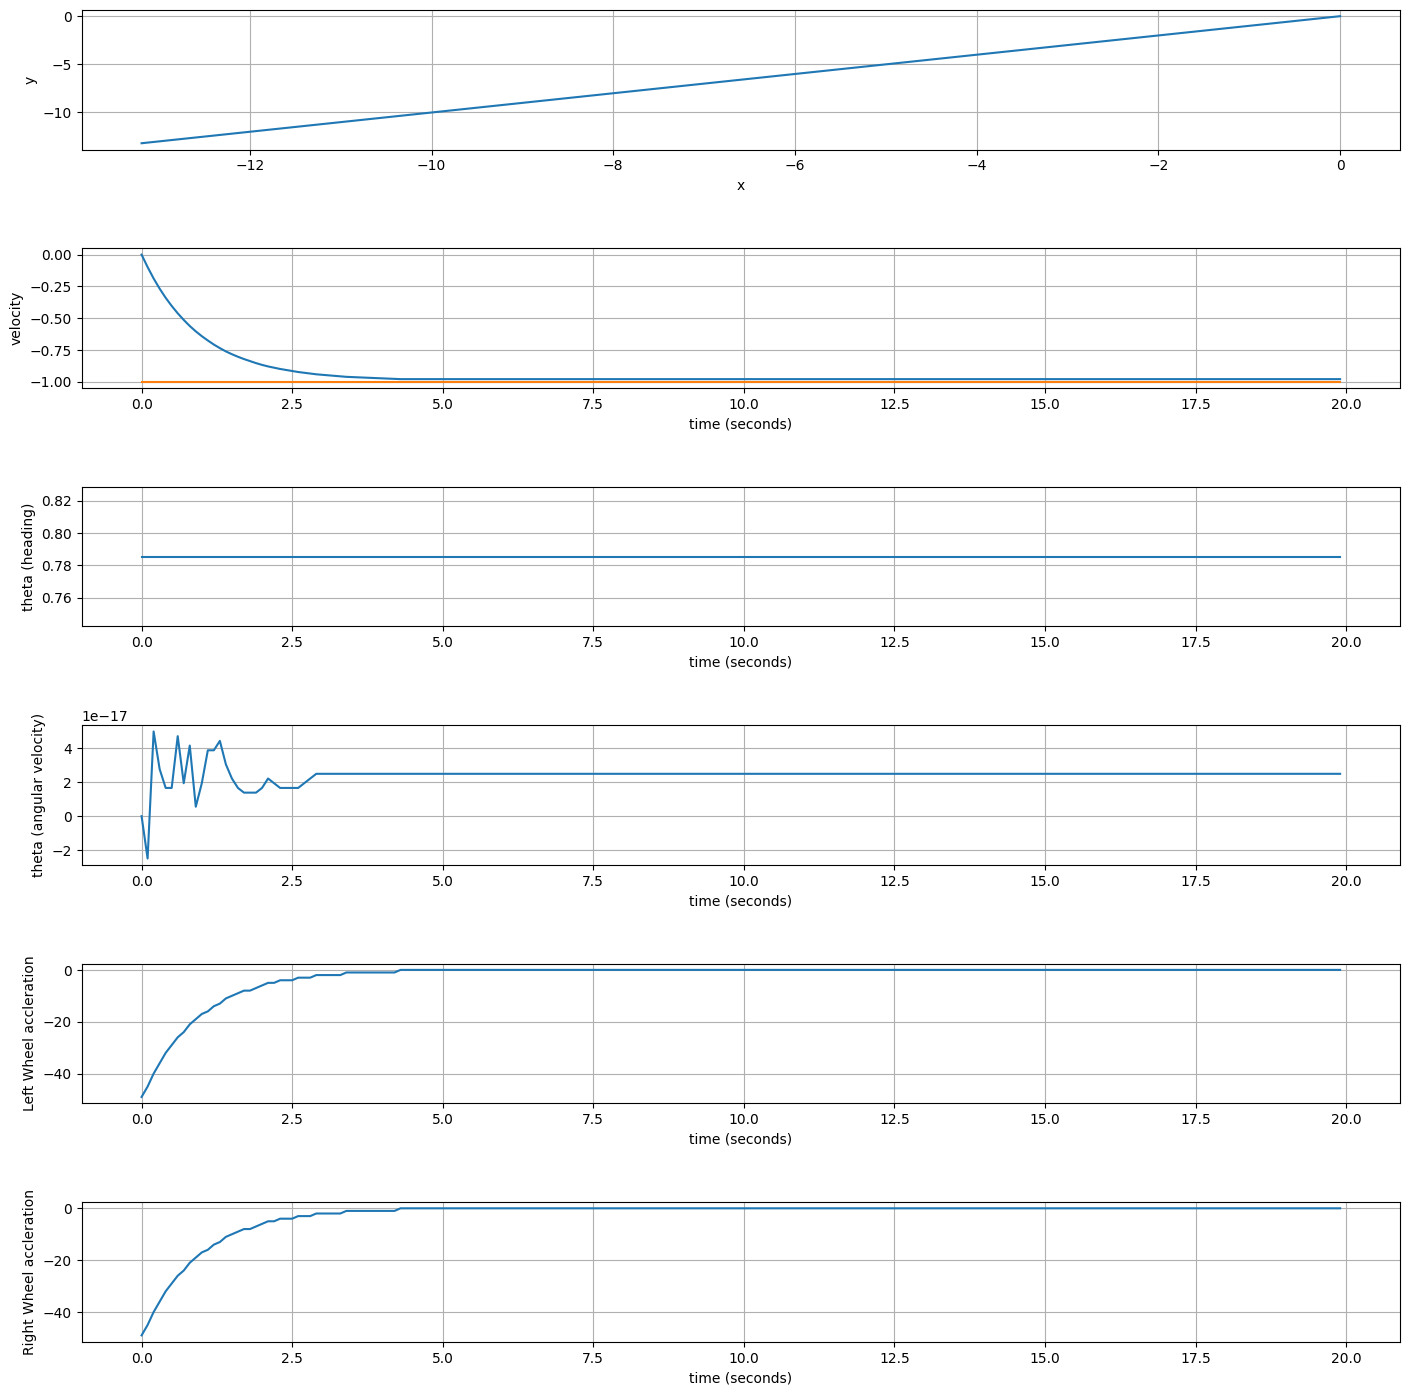

Percentage of overshoot for linear velocity: -2.00%
Ess (m) (linear velocity): -0.019999999999999574
Peak time (linear velocity): 4.3 seconds


In [41]:
#Description: This MPC aims to model the DDR to reach a linear velocity of -1 through finding the correct left and right wheel accelerations
#Source: This code takes code from the csc-340-MPC.ipynb, but is adapted to our model
#Source: The code for the overshoot, steady state error, and peak time come from HW5, these indicators are adapted for negative values

# setting up the numerical solution parameters
r,b,t_0, x_k, y_k,w_k, v_k,y_list, x_list,time_list,v_list, heading, ang_vel_list ,t, t_f, dt, theta_k = set_variables_back()

left_acceleration_values = []
right_acceleration_values = []
ref_values = []

v_d = -1 
accel_r_max = -50
accel_l_max = -50

dt = 0.1 # delta t = 0.1 second

x_0 =  0 
v_0 =  0 

r = 0.02  #radius of the wheel in meters
b = 0.05  #length of half of axle, in meters
t_0 = 0  #starting time 
t_f = 20  #ending time 
dt = 0.1 #time increment 
x_k =0   #original x value, 0 
y_k =0  #original y value, 0 

w_k = 0  #angular velocity
v_k = 0  #velocity

acc_l = 0  #acceleration of the left wheel 
acc_r = 0  #acceleration of the right wheel
theta_k = math.pi/4  #heading of the robot, set to pi/4 becuase of diagram wanted it to be easy to visualize 
y_list = []  #initializing y list
x_list = []  #initializing x list
time_list = []  #initializing time list
v_list=[]  #intializing velocity list 
heading = []  #intialiizing heading 
ang_vel_list = []  #intializing angular velocity list
t = t_0 #setting t to the start poistion

A = np.array([[r/2, r/2],
            [r/(2*b),-1 * r/(2*b)]])

B = np.array([[acc_l],[acc_r]])

v_w = np.array([[v_k],[w_k]])



############ MPC setup
# setting up the MPC solver
model_type = 'discrete' # either 'discrete' or 'continuous'
model = do_mpc.model.Model(model_type)
# define the states
v_lin = model.set_variable(var_type='_x', var_name='v_lin', shape=(1,1))
v_ang = model.set_variable(var_type='_x', var_name='v_ang', shape=(1,1))

# define the inputs
accel_l = model.set_variable(var_type='_u', var_name='accel_l')
accel_r = model.set_variable(var_type='_u', var_name='accel_r')
# setup the control goals
# avoid large forces
model.set_expression( expr_name="lagrange_term", expr= 0.00001* accel_l **2+ 0.00001* accel_r **2 )

# reach the final destinatioin (x_d) and stop
model.set_expression(
    expr_name="meyer_term", expr= 1000*(v_d - v_lin) ** 2+ 1* v_lin**2 
)
# include the dynamics in the model
model.set_rhs("v_lin", ((((accel_l * r)/2) + ((accel_r * r)/2))*dt + v_lin))
model.set_rhs("v_ang", ((((accel_l * r)/2) + ((accel_r * r)/2))*dt + v_ang))

# finish the setup
model.setup()
print('Model defined!')

# set up the MPC solver
mpc = do_mpc.controller.MPC(model)
mpc.settings.n_horizon = 10 # predict the next N steps
mpc.settings.t_step = dt 

lterm = model.aux["lagrange_term"]
mterm = model.aux["meyer_term"]

mpc.set_objective(lterm=lterm, mterm=mterm)
mpc.set_rterm(accel_l=0)
mpc.set_rterm(accel_r=0)

mpc.scaling['_x', 'v_lin'] = 1
mpc.scaling['_x', 'v_ang'] = 1

mpc.bounds["lower", "_u", "accel_l"] = accel_l_max
mpc.bounds["upper", "_u", "accel_l"] = -accel_l_max
              
mpc.bounds["lower", "_u", "accel_r"] = accel_r_max
mpc.bounds["upper", "_u", "accel_r"] = -accel_r_max
              
surpress_ipopt = {'ipopt.print_level':0, 'ipopt.sb': 'yes', 'print_time':0}
mpc.set_param(nlpsol_opts = surpress_ipopt)
mpc.setup()
print('MPC solver defined!')

# simulate the system
while t < t_f:
    ref_values.append(v_d)
    # set the solver for the current iteration    
    mpc.x0 = v_w
    mpc.set_initial_guess()
    u_opt = mpc.make_step(v_w) # find the optimal input

    
    B[0] = u_opt[0]
    B[1] = u_opt[1]
    
    right_acceleration_values.append(float(B[0]))
    left_acceleration_values.append(float(B[1]))
    
    v_list.append(v_k)
    x_list.append(x_k)
    y_list.append(y_k)
    time_list.append(t)
    heading.append(theta_k)
    ang_vel_list.append(w_k)
    
    v_w1 = (A.dot(B) * dt) + v_w
    v_w = v_w1
    v_k = float(v_w[0])
    w_k = float(v_w[1])
    
    theta_k1 = dt*(w_k) + theta_k
    theta_k = theta_k1
    x_k1 = dt*(math.cos(theta_k)*v_k)+x_k
    x_k = x_k1
    y_k1 = dt*(math.sin(theta_k)*v_k)+y_k
    y_k = y_k1
    t += dt
    

fig, axs = plt.subplots(6, 1, figsize=(15, 15))
fig.tight_layout(pad=5.0)


axs[0].plot(x_list,y_list)
axs[0].set_xlabel('x')
axs[0].set_ylabel('y')
axs[0].grid()

axs[1].plot(time_list, v_list)
axs[1].plot(time_list, ref_values)
axs[1].set_xlabel('time (seconds)')
axs[1].set_ylabel('velocity')
axs[1].grid()

axs[2].plot(time_list, heading)
axs[2].set_xlabel('time (seconds)')
axs[2].set_ylabel('theta (heading)')
axs[2].grid()

axs[3].plot(time_list, ang_vel_list)
axs[3].set_xlabel('time (seconds)')
axs[3].set_ylabel('theta (angular velocity)')
axs[3].grid()

axs[4].plot(time_list, left_acceleration_values)
axs[4].set_xlabel('time (seconds)')
axs[4].set_ylabel('Left Wheel accleration')
axs[4].grid()

axs[5].plot(time_list, right_acceleration_values)
axs[5].set_xlabel('time (seconds)')
axs[5].set_ylabel('Right Wheel accleration')
axs[5].grid()
    
plt.show()
              
# estimate the overshoot
OS = (np.min(v_list)-v_d)/v_d*100
print('Percentage of overshoot for linear velocity:',format(OS,'.2f'),'\b%')

# estimate the steady-state error for linear velocity
e_ss = v_d - v_k
print('Ess (m) (linear velocity):',e_ss)

# estimate the peak time for linear velocity 
tp = np.argmin(v_list)*dt
print('Peak time (linear velocity):',tp,'seconds')


Explanation: When I set the desired velocity to -1. I mostly just want to test the capabilities of the MPC. This plot looks exactly like I would expect it to look. Like the opposite of having a desired positive velocity. Instead of the wheel acceleration going from 25 to eventually 0, this one start at -25 and ends at 0 as well. It is important to check the model that the negative values work as well as this could be a possibility in the real life modeling of this DDR. 

### EX #4: W = -1

Model defined!
MPC solver defined!


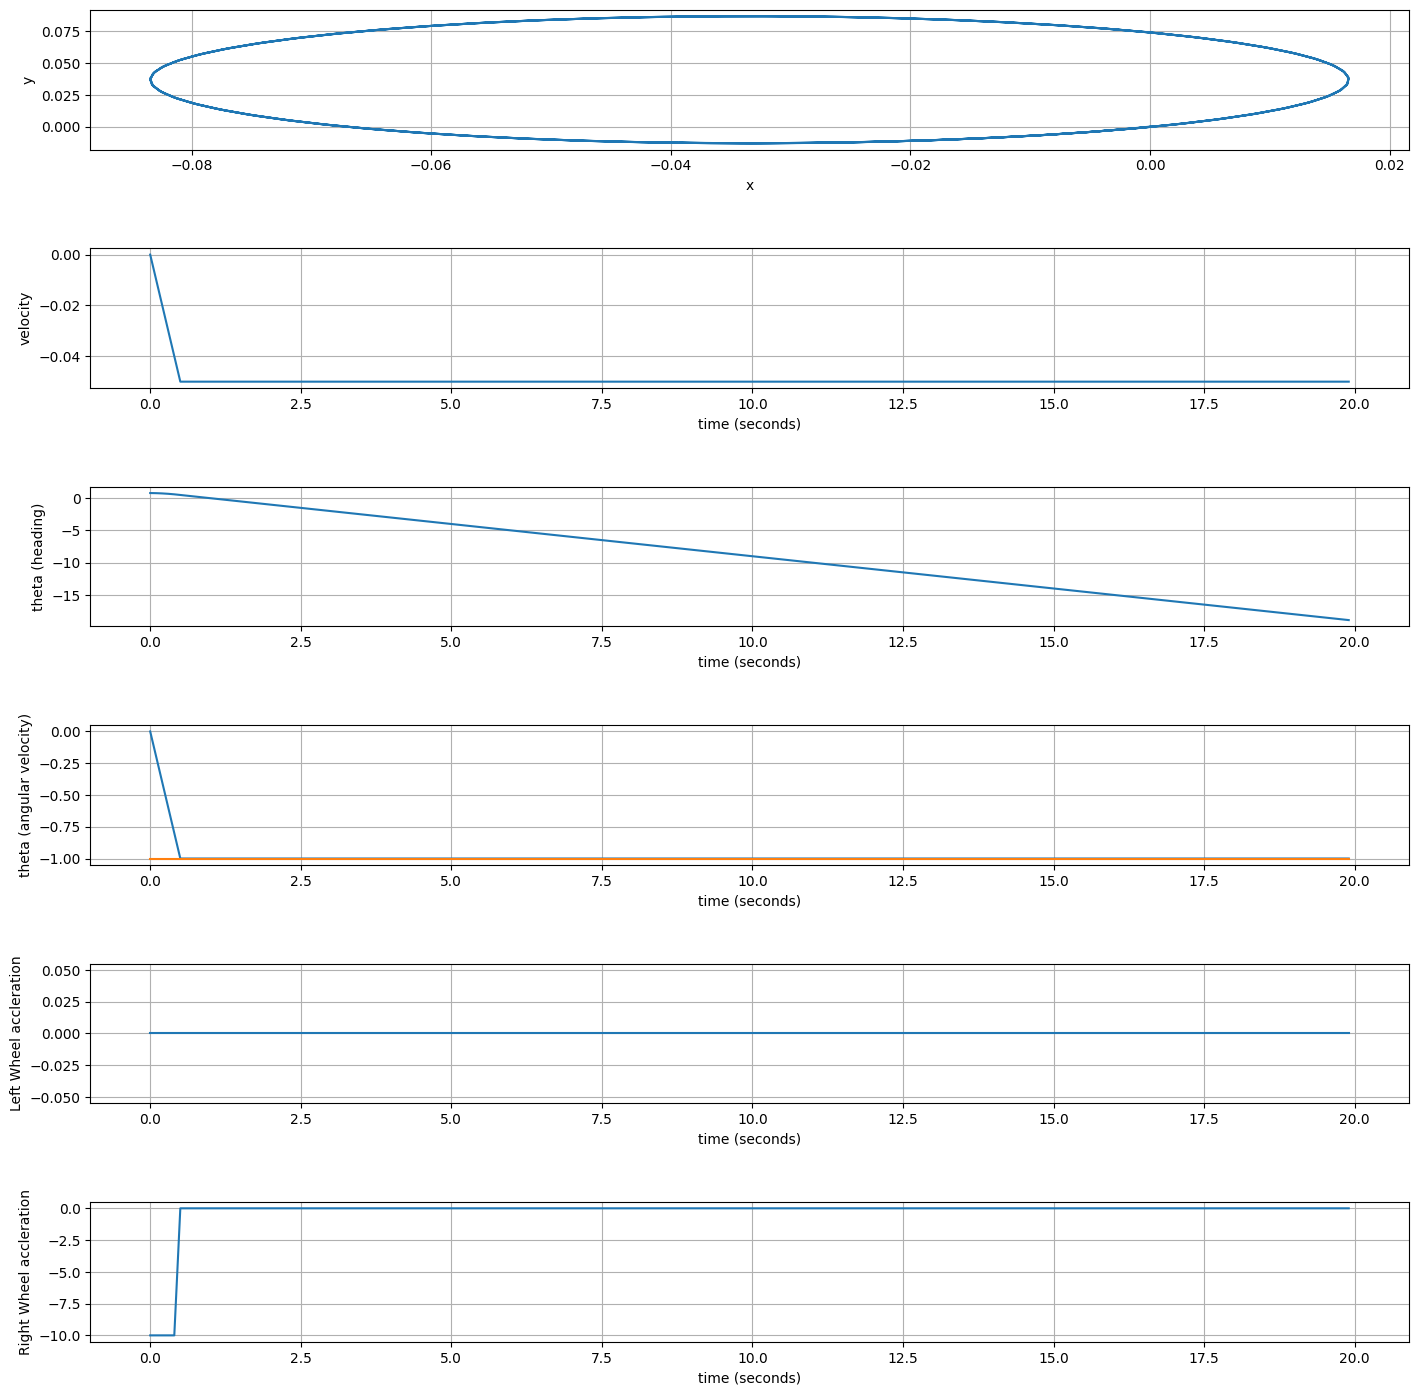

Percentage of overshoot (angular linear velocity): -0.00%
Ess (m) (Angular linear velocity)): -1.1102230246251565e-16
Peak time (Angular linear velocity): 0.5 seconds


In [42]:

#Description: This MPC aims to model the DDR to reach an angular velocity of -1 through finding the correct left and right wheel accelerations
#Source: This code takes code from the csc-340-MPC.ipynb, but is adapted to our model
#Source: The code for the overshoot, steady state error, and peak time come from HW5 these indicators are adapted for negative values

# setting up the numerical solution parameters
r,b,t_0, x_k, y_k,w_k, v_k,y_list, x_list,time_list,v_list, heading, ang_vel_list ,t, t_f, dt, theta_k = set_variables_back()

left_acceleration_values = []
right_acceleration_values = []
ref_values = []

w_d = -1 
accel_r_max = 0
accel_l_max = 10

dt = 0.1 # delta t = 0.1 second

x_0 =  0 
v_0 =  0 

r = 0.02  #radius of the wheel in meters
b = 0.05  #length of half of axle, in meters
t_0 = 0  #starting time 
t_f = 20  #ending time 
dt = 0.1 #time increment 
x_k =0   #original x value, 0 
y_k =0  #original y value, 0 

w_k = 0  #angular velocity
v_k = 0  #velocity

acc_l = 0  #acceleration of the left wheel 
acc_r = 0  #acceleration of the right wheel
theta_k = math.pi/4  #heading of the robot, set to pi/4 becuase of diagram wanted it to be easy to visualize 
y_list = []  #initializing y list
x_list = []  #initializing x list
time_list = []  #initializing time list
v_list=[]  #intializing velocity list 
heading = []  #intialiizing heading 
ang_vel_list = []  #intializing angular velocity list
t = t_0 #setting t to the start poistion

A = np.array([[r/2, r/2],
            [r/(2*b),-1 * r/(2*b)]])

B = np.array([[acc_l],[acc_r]])

v_w = np.array([[v_k],[w_k]])



############ MPC setup
# setting up the MPC solver
model_type = 'discrete' # either 'discrete' or 'continuous'
model = do_mpc.model.Model(model_type)
# define the states
v_lin = model.set_variable(var_type='_x', var_name='v_lin', shape=(1,1))
v_ang = model.set_variable(var_type='_x', var_name='v_ang', shape=(1,1))

# define the inputs
accel_l = model.set_variable(var_type='_u', var_name='accel_l')
accel_r = model.set_variable(var_type='_u', var_name='accel_r')
# setup the control goals
# avoid large forces
model.set_expression( expr_name="lagrange_term", expr= 0.00001* accel_l **2+ 0.00001* accel_r **2 )

# reach the final destinatioin (x_d) and stop
model.set_expression(
    expr_name="meyer_term", expr= 1000*(w_d - v_ang) ** 2+ 1* v_lin**2 
)
# include the dynamics in the model
model.set_rhs("v_lin", ((((accel_l * r)/2) + ((accel_r * r)/2))*dt + v_lin))
model.set_rhs("v_ang", ((((accel_l * r)/2) + ((accel_r * r)/2))*dt + v_ang))

# finish the setup
model.setup()
print('Model defined!')

# set up the MPC solver
mpc = do_mpc.controller.MPC(model)
mpc.settings.n_horizon = 10 # predict the next N steps
mpc.settings.t_step = dt 

lterm = model.aux["lagrange_term"]
mterm = model.aux["meyer_term"]

mpc.set_objective(lterm=lterm, mterm=mterm)
mpc.set_rterm(accel_l=0)
mpc.set_rterm(accel_r=0)

mpc.scaling['_x', 'v_lin'] = 1
mpc.scaling['_x', 'v_ang'] = 1

mpc.bounds["lower", "_u", "accel_l"] = -accel_l_max
mpc.bounds["upper", "_u", "accel_l"] = accel_l_max
              
mpc.bounds["lower", "_u", "accel_r"] = -accel_r_max
mpc.bounds["upper", "_u", "accel_r"] = accel_r_max
              
surpress_ipopt = {'ipopt.print_level':0, 'ipopt.sb': 'yes', 'print_time':0}
mpc.set_param(nlpsol_opts = surpress_ipopt)
mpc.setup()
print('MPC solver defined!')

# simulate the system
while t < t_f:
    ref_values.append(w_d)
    # set the solver for the current iteration    
    mpc.x0 = v_w
    mpc.set_initial_guess()
    u_opt = mpc.make_step(v_w) # find the optimal input

    
    B[0] = u_opt[0]
    B[1] = u_opt[1]
    
    right_acceleration_values.append(float(B[0]))
    left_acceleration_values.append(float(B[1]))
    
    v_list.append(v_k)
    x_list.append(x_k)
    y_list.append(y_k)
    time_list.append(t)
    heading.append(theta_k)
    ang_vel_list.append(w_k)
    
    v_w1 = (A.dot(B) * dt) + v_w
    v_w = v_w1
    v_k = float(v_w[0])
    w_k = float(v_w[1])
    
    theta_k1 = dt*(w_k) + theta_k
    theta_k = theta_k1
    x_k1 = dt*(math.cos(theta_k)*v_k)+x_k
    x_k = x_k1
    y_k1 = dt*(math.sin(theta_k)*v_k)+y_k
    y_k = y_k1
    t += dt
    

fig, axs = plt.subplots(6, 1, figsize=(15, 15))
fig.tight_layout(pad=5.0)


axs[0].plot(x_list,y_list)
axs[0].set_xlabel('x')
axs[0].set_ylabel('y')
axs[0].grid()

axs[1].plot(time_list, v_list)
axs[1].set_xlabel('time (seconds)')
axs[1].set_ylabel('velocity')
axs[1].grid()

axs[2].plot(time_list, heading)
axs[2].set_xlabel('time (seconds)')
axs[2].set_ylabel('theta (heading)')
axs[2].grid()

axs[3].plot(time_list, ang_vel_list)
axs[3].plot(time_list, ref_values)
axs[3].set_xlabel('time (seconds)')
axs[3].set_ylabel('theta (angular velocity)')
axs[3].grid()

axs[4].plot(time_list, left_acceleration_values)
axs[4].set_xlabel('time (seconds)')
axs[4].set_ylabel('Left Wheel accleration')
axs[4].grid()

axs[5].plot(time_list, right_acceleration_values)
axs[5].set_xlabel('time (seconds)')
axs[5].set_ylabel('Right Wheel accleration')
axs[5].grid()
    
plt.show()
              
# estimate the angular linear overshoot
OS = (np.min(ang_vel_list)-w_d)/w_d*100
print('Percentage of overshoot (angular linear velocity):',format(OS,'.2f'),'\b%')

# estimate the angular velocity steady-state error
e_ss = w_d - w_k
print('Ess (m) (Angular linear velocity)):',e_ss)

# estimate the peak time for angular velocity
tp = np.argmin(ang_vel_list)*dt
print('Peak time (Angular linear velocity):',tp,'seconds')




Explanation: This one again is testing the capabilities of the MPC and seeing if it still produces meaningful plots when the desired value is negative. This plot looks exactly like it should be, like the oppositve of having the angular velocity being poisitive 1. The MPC does what its meant to and controls the right acceleration in order to reach a negative angular velocity. It moves the right wheel backwards, this would be the same as if the left wheel was moving in a positive direction, since the heading would decrease across as the DDR goes across the x-axis. 

# Section 7
## Discussion and conclusions: 

In conclusion the MPC seems to be a more accurate way of modeling the DDR for a desired variable than the PID. The MPC produces smoother, more accurate plots. The real drawback with this model is that there is no dampening of the velocity, whether that be the angular or linear velocity. It is hard to have plots that would mimick the real life models of this DDR since in real life, the DDR would eventually slow down if it reaches a target velocity and the wheel accelerations drop down to zero. In our plots the DDR continues to move. Using a PID or a MPC with a model that has velocity dampening would make plots more meaningful and would relate more to the real life equivalent. Another note on the difference between modeling with a PID and MPC, is that a PID is a lot more difficult becuase instead of solving the problem it requires an input of the PID values (Kp, Kd, Ki). Finding these values are difficult and incorrect values can cause the model to appear incorrect. The strength of the PID and the MPC lie in the fact that they can change the input in order to result in a desired variable. The MPC seems to do this more efficiently than the PID. The limitations of the PID appear evident when we try and model for a desired angular velocity of 1, in which the matrix solved accelerations are 2.5, and -2.5 for right wheel acceleration and left wheel accleration, respectively. The PID can't seem to get these wheel accelerations to 1 and instead keeps on alternating them to cancel them out effectively. Now, this may be due part to an improper implementation but another explantion may be that the PID is not complex enough or that is simply how the PID solves the problem. A limitation of the MPC lies when trying to input a negative max as the bounds have to be swapped and it doesn't seem to be able to solve for an angular velocity when the right wheel acceleration is 2.5 and a left wheel acceleration of -2.5. The bounds become inverses of each other and it would take a lot of reformatting to get these values to work. 